In [3]:
#############################
# 필요 라이브러리 사전설치
#############################

!pip install fredapi pandas numpy seaborn scikit-learn xgboost flask scikit-optimize openpyxl plotly tensorflow statsmodels matplotlib pywebpush joblib graphviz
#(Option) !pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.1 MB/s eta 0:00:00


In [17]:
#############################
# fred를 통한 미국 경제데이터 API 호출 (2000~2024년)
#############################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from fredapi import Fred
import warnings

#Deafult Settings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 한글 폰트 설정
font_path = 'font/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())

fred_api_key = os.getenv("FRED_API_KEY") # 사용하는 Fred API Key 가져오기
fred_data = Fred(api_key=fred_api_key)

# 시리즈 ID 목록
series_ids = {
    'us_gdp': 'GDP',  # 미국 GDP
    'us_interest_rate': 'FEDFUNDS',  # 미연준 금리
    'us_inflation_expectations': 'T5YIE',  # 미국 기대 인플레이션
    'us_nonfarm_employment': 'PAYEMS',  # 미국 비농업 고용 지수
    'us_unemployment_rate': 'UNRATE',  # 미국 실업률 지수
    'us_consumer_prices': 'CPIAUCSL',  # 미국 소비자 물가 지수
    'world_oil_prices' : 'DCOILWTICO'  # WTI 유가 가격지수
}

# 데이터 수집
dataframes = {}
for key, series_id in series_ids.items():
    data = fred_data.get_series(series_id, observation_start='2000-01-01', observation_end='2024-04-30')
    dataframes[key] = data

# 각 시리즈를 하나의 DataFrame으로 병합
fred = pd.DataFrame(dataframes)
fred.to_excel("Data/Summary/fred.xlsx")
fred

us_gdp  us_interest_rate  us_inflation_expectations  \
2000-01-01  10002.179              5.45                        NaN   
2000-01-03        NaN               NaN                        NaN   
2000-01-04        NaN               NaN                        NaN   
2000-01-05        NaN               NaN                        NaN   
2000-01-06        NaN               NaN                        NaN   
...               ...               ...                        ...   
2024-04-24        NaN               NaN                       2.42   
2024-04-25        NaN               NaN                       2.43   
2024-04-26        NaN               NaN                       2.44   
2024-04-29        NaN               NaN                       2.43   
2024-04-30        NaN               NaN                       2.43   

            us_nonfarm_employment  us_unemployment_rate  us_consumer_prices  \
2000-01-01               131009.0                   4.0               169.3   
2000-01-03                    NaN                   NaN                 NaN   
2000-01-04                    NaN                   NaN                 NaN   
2000-01-05                    NaN                   NaN                 NaN   
2000-01-06                    NaN                   NaN                 NaN   
...                           ...                   ...                 ...   
2024-04-24                    NaN                   NaN                 NaN   
2024-04-25                    NaN                   NaN                 NaN   
2024-04-26                    NaN                   NaN                 NaN   
2024-04-29                    NaN                   NaN                 NaN   
2024-04-30                    NaN                   NaN                 NaN   

            world_oil_prices  
2000-01-01               NaN  
2000-01-03               NaN  
2000-01-04             25.56  
2000-01-05             24.65  
2000-01-06             24.79  
...                      ...  
2024-04-24             84.09  
2024-04-25             84.92  
2024-04-26             85.38  
2024-04-29             84.26  
2024-04-30             83.49  

[6430 rows x 7 columns]

결측치 확인:
us_gdp                       6333
us_interest_rate             6138
us_inflation_expectations    1093
us_nonfarm_employment        6138
us_unemployment_rate         6138
us_consumer_prices           6138
world_oil_prices              326
dtype: int64
결측치 처리 후 확인:
us_gdp                         0
us_interest_rate               0
us_inflation_expectations    794
us_nonfarm_employment          0
us_unemployment_rate           0
us_consumer_prices             0
world_oil_prices               2
dtype: int64
정규화된 데이터:
              us_gdp  us_interest_rate  us_inflation_expectations  \
Date                                                                
2000-01-31  0.000000          0.853328                        NaN   
2000-02-29  0.004384          0.884710                        NaN   
2000-03-31  0.008871          0.906941                        NaN   
2000-04-30  0.011903          0.938976                        NaN   
2000-05-31  0.013190          0.978345                      

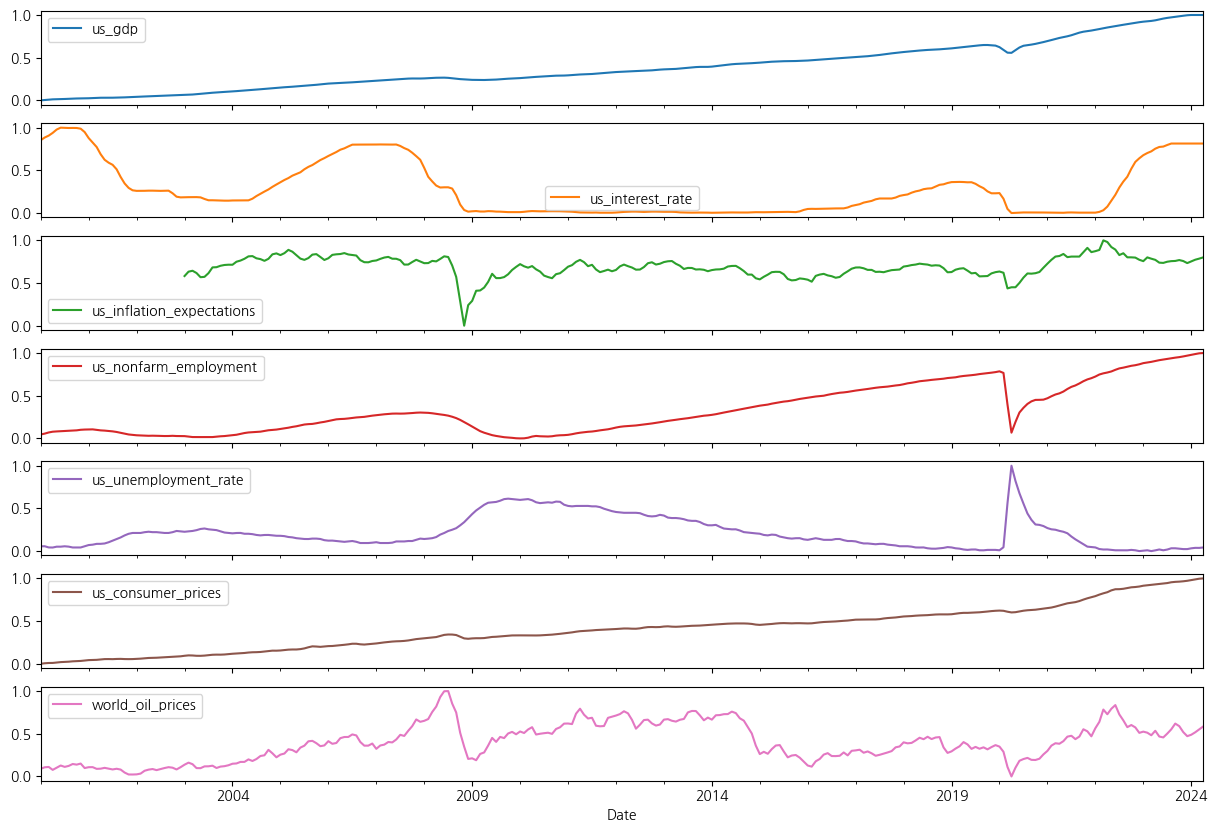

In [20]:
#############################
# fred 데이터 정규화 및 결측치 제거
#############################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from fredapi import Fred

# 한글 폰트 설정
font_path = 'font/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())

# 데이터 불러오기
fred = pd.read_excel("Data/Summary/fred.xlsx")
# 열 이름 변경
fred.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
# Date 열을 인덱스로 설정
fred.set_index('Date', inplace=True)
fred.index = pd.to_datetime(fred.index)

# 결측치 확인
print("결측치 확인:")
print(fred.isnull().sum())

# 결측치 처리 (예시: 선형 보간법 사용)
fred.interpolate(method='linear', inplace=True)

# 결측치가 있는지 확인
print("결측치 처리 후 확인:")
print(fred.isnull().sum())

# 월별 데이터로 변환 (각 월의 평균값 사용)
monthly_fred = fred.resample('M').mean()

# MinMax 정규화
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(monthly_fred)

# 정규화된 데이터를 DataFrame으로 변환
normalized_fred = pd.DataFrame(scaled_data, index=monthly_fred.index, columns=monthly_fred.columns)

# 결과 확인
print("정규화된 데이터:")
print(normalized_fred.head())

# 데이터 저장
normalized_fred.to_excel('Data/Summary/normalized_monthly_fred_data.xlsx')

# 데이터 확인 및 시각화
import matplotlib.pyplot as plt

normalized_fred.plot(subplots=True, figsize=(15, 10))
plt.savefig("picture/1-Each_US_economics.png")
plt.show()

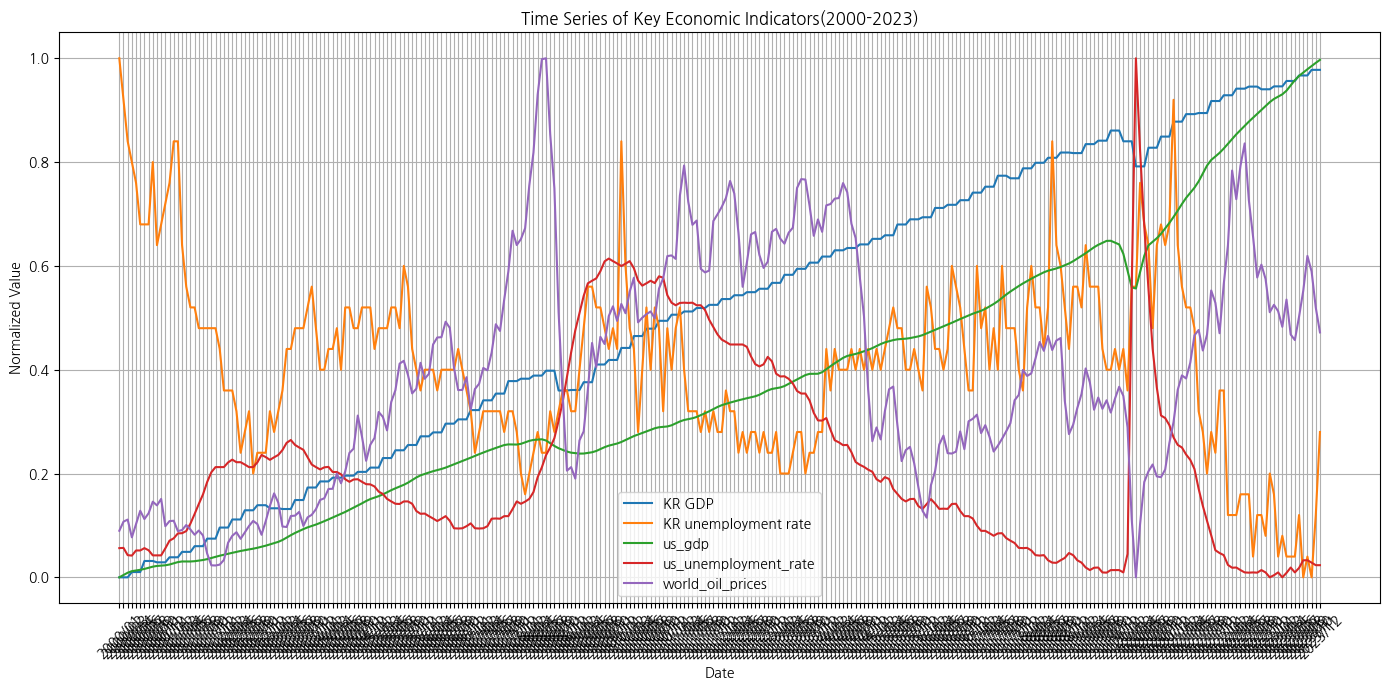

In [222]:
#############################
# 월별 한국데이터 및 연간 한국데이터(2000~2024년) 결합 후 fred 데이터와 최종 결합 (= MacroEconomics.xlsx)
#############################

import pandas as pd

# 제공된 월별 및 연간 Excel 파일 로드
monthly_data_path = 'Data/Summary/KR_summary_monthly.xlsx' # 월별 한국 경제데이터
yearly_data_path = 'Data/Summary/KR_summary_yearly.xlsx' # 연간 한국 경제데이터
fred_data_path = 'Data/Summary/normalized_monthly_fred_data.xlsx' # 월별 정규화된 FRED 데이터

monthly_df = pd.read_excel(monthly_data_path)
yearly_df = pd.read_excel(yearly_data_path)
fred_df = pd.read_excel(fred_data_path)

# 연간 데이터를 월별 형식으로 변환
yearly_data_melted = yearly_df.melt(id_vars=['Data'], var_name='Year', value_name='Value')

# 연간 데이터에서 월별 데이터로 데이터 프레임 생성
yearly_data_monthly_list = []
for index, row in yearly_data_melted.iterrows():
    for month in range(1, 13):
        monthly_row = {
            'Data': row['Data'],
            'Date': f"{row['Year']}/{month:02d}",
            'Value': row['Value']
        }
        yearly_data_monthly_list.append(monthly_row)
yearly_data_monthly = pd.DataFrame(yearly_data_monthly_list)

# 원래 월별 데이터의 형식과 일치하도록 데이터 프레임을 피벗
yearly_pivot = yearly_data_monthly.pivot(index='Data', columns='Date', values='Value')

# 월별 및 연간 데이터 프레임 결합
combined_df = monthly_df.set_index('Data').combine_first(yearly_pivot)

#각 행의 중앙값으로 결측값 채우기
combined_df = combined_df.apply(lambda row: row.fillna(row.median()), axis=1)

# FRED 데이터의 'Date' 열을 결합된 데이터의 형식과 일치하도록 변환합니다
fred_df['Date'] = pd.to_datetime(fred_df['Date']).dt.strftime('%Y/%m')

# 결합된 데이터의 형식과 일치하도록 FRED 데이터의 위치를 바꿉니다
fred_transposed = fred_df.set_index('Date').T

#두 데이터 세트를 결합
combined_normalized_df = combined_df.combine_first(fred_transposed).T

# 각 열에 대해 MinMax 정규화 수행
normalized_df = combined_normalized_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

# 'Date'를 다시 열로 만들기 위해 인덱스 재설정
normalized_df.reset_index(inplace=True)

# 정규화된 데이터 프레임을 Excel 파일에 저장
normalized_excel_path = 'Data/Summary/MacroEconomics.xlsx'
normalized_df.to_excel(normalized_excel_path, index=False)

# 그림을 그릴 몇 개의 핵심 열 선택
selected_columns = ['KR GDP', 'KR unemployment rate', 'us_gdp', 'us_unemployment_rate', 'world_oil_prices']

# 선택한 열 그림 그리기
def plot_time_series(data, columns, title):
    plt.figure(figsize=(14, 7))
    for column in columns:
        sns.lineplot(x=data['index'], y=data[column], label=column)
    plt.xlabel('Date')
    plt.ylabel('Normalized Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("picture/2-Time Series of Key Economic Indicators.png")
    plt.show()


# 'index' 열이 datetime 형식이라면 문자열로 변환합니다.
normalized_df['index_str'] = normalized_df['index'].astype(str)
# '2024'가 포함된 행을 제외합니다.
normalized_df_filtered = normalized_df[~normalized_df['index_str'].str.contains('2024')]
# 불필요한 'index_str' 열을 제거합니다.
normalized_df_adjust = normalized_df_filtered.drop(columns=['index_str'])
#plot_time_series(normalized_df, selected_columns, 'Time Series of Key Economic Indicators(2000-2023)')
plot_time_series(normalized_df_adjust, selected_columns, 'Time Series of Key Economic Indicators(2000-2023)')


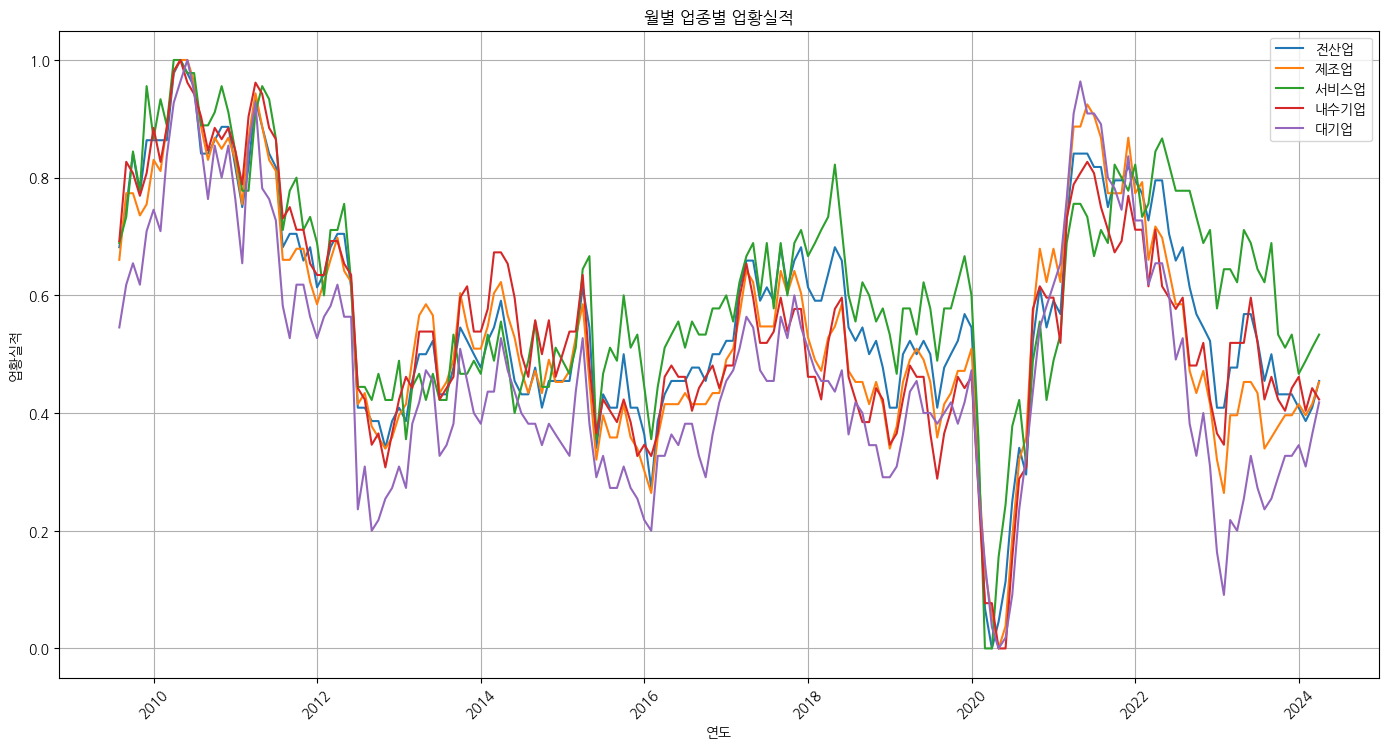

업종_BSI      제조업_가동률실적  식료품_가동률실적  음료_가동률실적  섬유_가동률실적  의복모피_가동률실적  \
2009-08-01   0.571429   0.735294  0.610169    0.6875    0.706667   
2009-09-01   0.682540   1.000000  0.677966    0.6375    0.773333   
2009-10-01   0.761905   0.764706  0.559322    0.7750    0.813333   
2009-11-01   0.730159   0.764706  0.271186    0.7500    0.946667   
2009-12-01   0.714286   0.558824  0.389831    0.7500    0.933333   
...               ...        ...       ...       ...         ...   
2023-12-01   0.396825   0.470588  0.237288    0.3125    0.466667   
2024-01-01   0.412698   0.441176  0.389831    0.3875    0.520000   
2024-02-01   0.428571   0.470588  0.169492    0.4375    0.546667   
2024-03-01   0.380952   0.235294  0.305085    0.4750    0.560000   
2024-04-01   0.476190   0.352941  0.186441    0.5125    0.666667   

업종_BSI      가죽·가방·신발_가동률실적  목재·나무_가동률실적  펄프·종이_가동률실적  인쇄·기록매체복제_가동률실적  \
2009-08-01        0.670103     0.836066     0.466667         0.619048   
2009-09-01        0.742268     0.7704

In [41]:
#############################
# 각 업종별 개별실적 로드 후 정규화
#############################

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the BSI data
bsi_data_path = 'Data/산업/KR_bsi.xlsx'
bsi_df = pd.read_excel(bsi_data_path)

# Separate data by BSI code
bsi_code_groups = bsi_df.groupby('BSI코드별')

# Function to handle missing values and apply MinMax normalization
def process_bsi_data(group):
    numeric_data = group.select_dtypes(include=[float, int]).copy()
    # Fill missing values with the median of each column
    group_filled = numeric_data.fillna(numeric_data.median(axis=0))
    
    # Apply MinMax normalization
    normalized_group = group_filled.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
    
    # Add the '업종코드별' column back to the dataframe
    normalized_group['업종코드별'] = group['업종코드별']
    
    return normalized_group

# Process each BSI code group
processed_bsi_groups = {bsi_code: process_bsi_data(group) for bsi_code, group in bsi_code_groups}

# Combine all processed groups into a single DataFrame
normalized_bsi_df = pd.concat(processed_bsi_groups, keys=processed_bsi_groups.keys()).reset_index(level=0).rename(columns={'level_0': 'BSI코드별'})

# Save the normalized dataframe to an Excel file
normalized_bsi_excel_path = 'Data/Summary/Normalized_BSI_Data.xlsx'
normalized_bsi_df.to_excel(normalized_bsi_excel_path, index=False)


# 월별 업종별 업황실적 시각화
normalized_bsi_df['업종_BSI'] = normalized_bsi_df['업종코드별'] + '_' + normalized_bsi_df['BSI코드별']
normalized_bsi_df = normalized_bsi_df.drop(columns=['업종코드별', 'BSI코드별']).set_index('업종_BSI').transpose()
normalized_bsi_df.index = pd.to_datetime(normalized_bsi_df.index, format='%Y/%m')

plt.figure(figsize=(14, 7))
sns.lineplot(normalized_bsi_df["전산업_업황실적"], label="전산업")
sns.lineplot(normalized_bsi_df["제조업_업황실적"], label="제조업")
sns.lineplot(normalized_bsi_df["서비스업_업황실적"], label="서비스업")
sns.lineplot(normalized_bsi_df["내수기업_업황실적"], label="내수기업")
sns.lineplot(normalized_bsi_df["대기업_업황실적"], label="대기업")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlabel("연도")
plt.xticks(rotation=45)
plt.ylabel("업황실적")
plt.title("월별 업종별 업황실적")
plt.savefig("picture/2-2-Time Series of Key Each BSI Indicators.png")
plt.show()

print(normalized_bsi_df)

EDA Summary Statistics
                               index     KR CCSI  KR CN currency  \
count                            173  173.000000      173.000000   
mean   2016-09-30 14:17:20.462427648    0.623956        0.314556   
min              2009-08-01 00:00:00    0.062963        0.000000   
25%              2013-03-01 00:00:00    0.551852        0.231958   
50%              2016-10-01 00:00:00    0.624074        0.270963   
75%              2020-05-01 00:00:00    0.714815        0.273561   
max              2023-12-01 00:00:00    1.000000        1.000000   
std                              NaN    0.147501        0.197214   

       KR EU currency      KR GDI      KR GDP      KR GNI  KR JP currency  \
count      173.000000  173.000000  173.000000  173.000000      173.000000   
mean         0.450714    0.720049    0.716568    0.758672        0.441767   
min          0.226275    0.386761    0.410034    0.402799        0.150163   
25%          0.368283    0.528742    0.567329    0.55957

/var/folders/_x/85c_20bd0yg0yw7bsqgk4qbh0000gp/T/ipykernel_33309/2729195558.py:98: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig("picture/3-Correlation macro with bsi.png")


<Figure size 2000x1500 with 0 Axes>

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


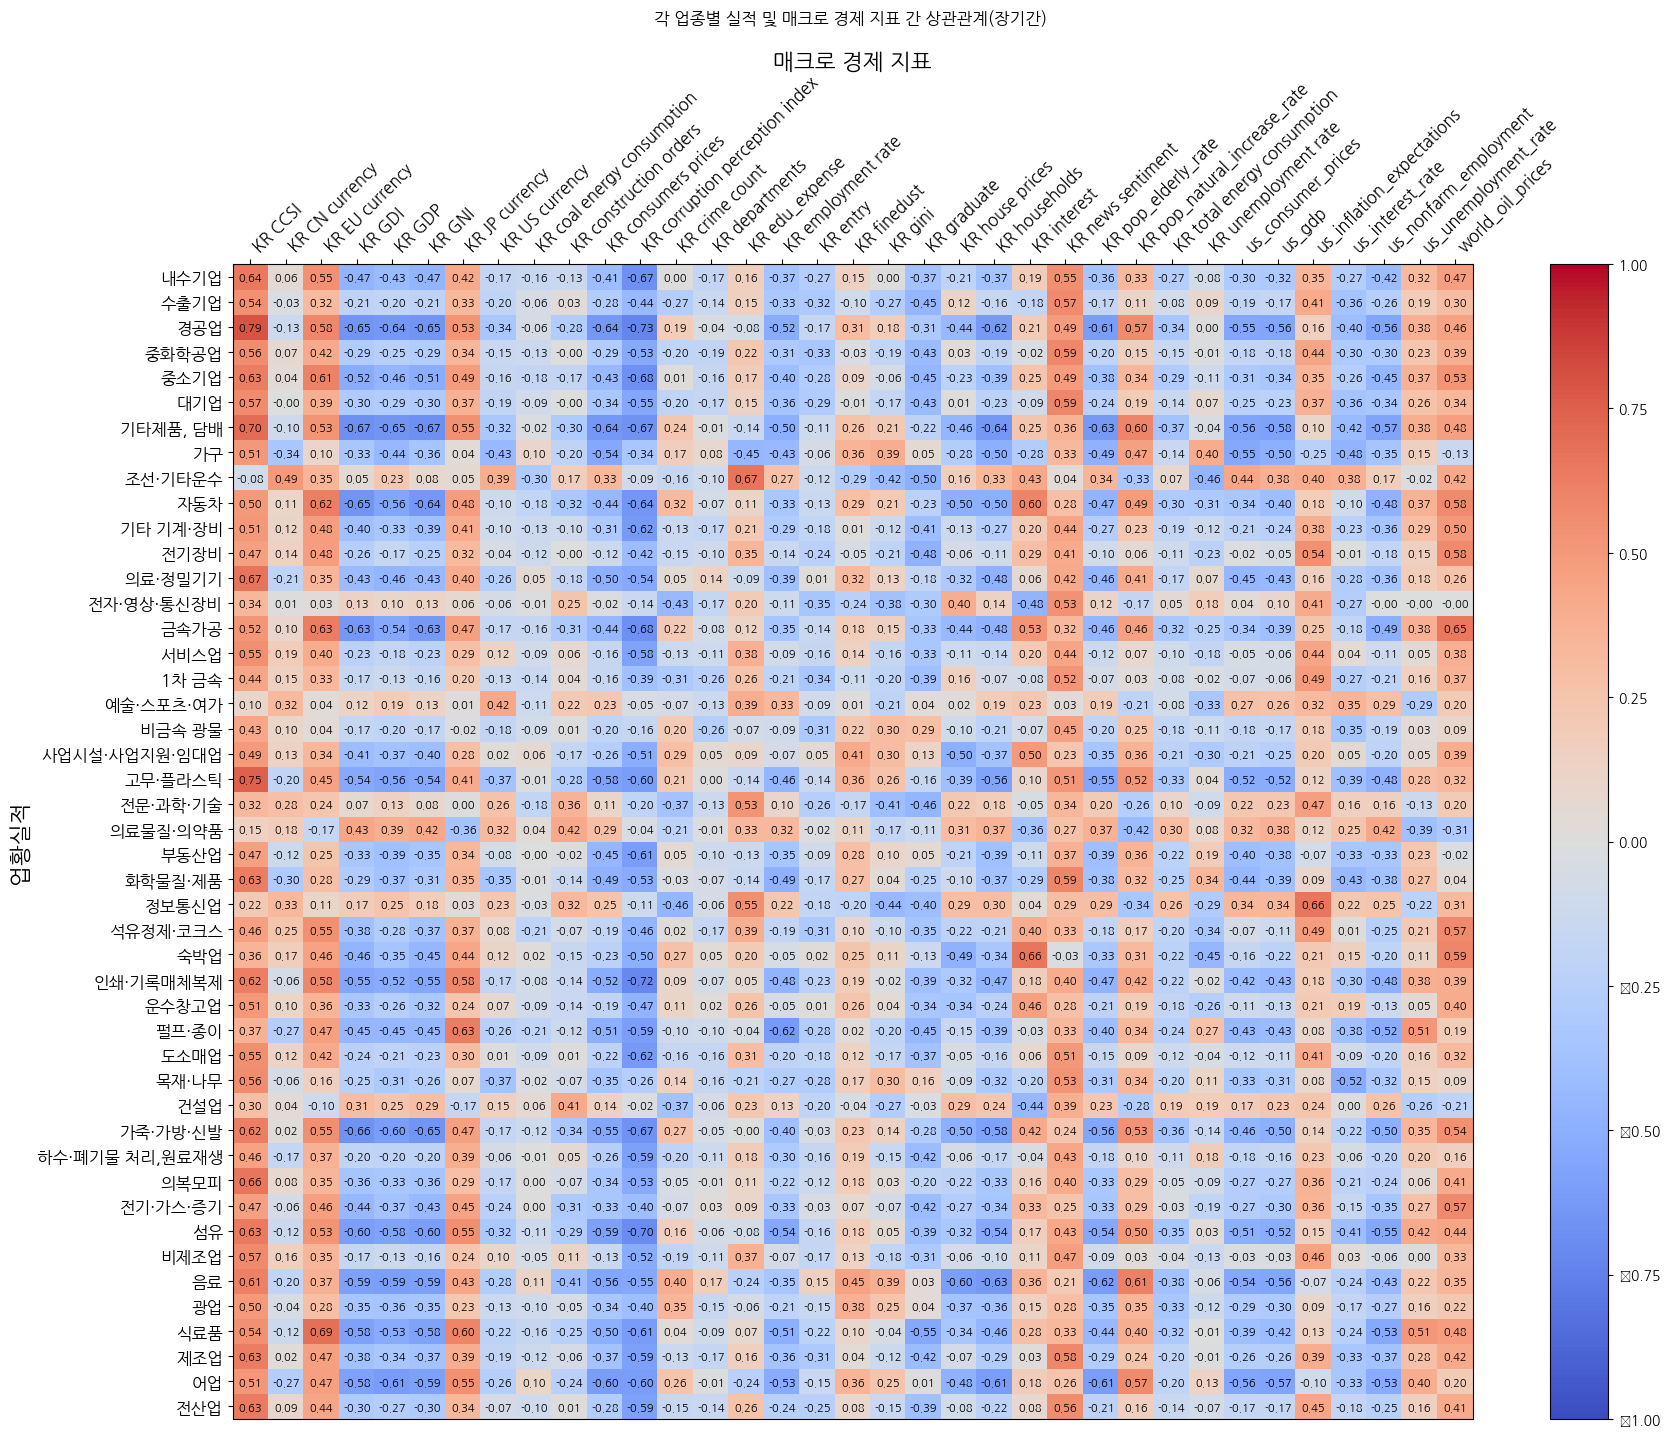

                            OLS Regression Results                            
Dep. Variable:               전산업_업황실적   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     115.4
Date:                Sun, 26 May 2024   Prob (F-statistic):           6.72e-21
Time:                        10:19:02   Log-Likelihood:                 93.669
No. Observations:                 173   AIC:                            -183.3
Df Residuals:                     171   BIC:                            -177.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0835      0.047      1.779      0.0

/var/folders/_x/85c_20bd0yg0yw7bsqgk4qbh0000gp/T/ipykernel_33309/2729195558.py:145: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig("picture/4-PCA of Macro Economic Indicators and BSI.png")
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


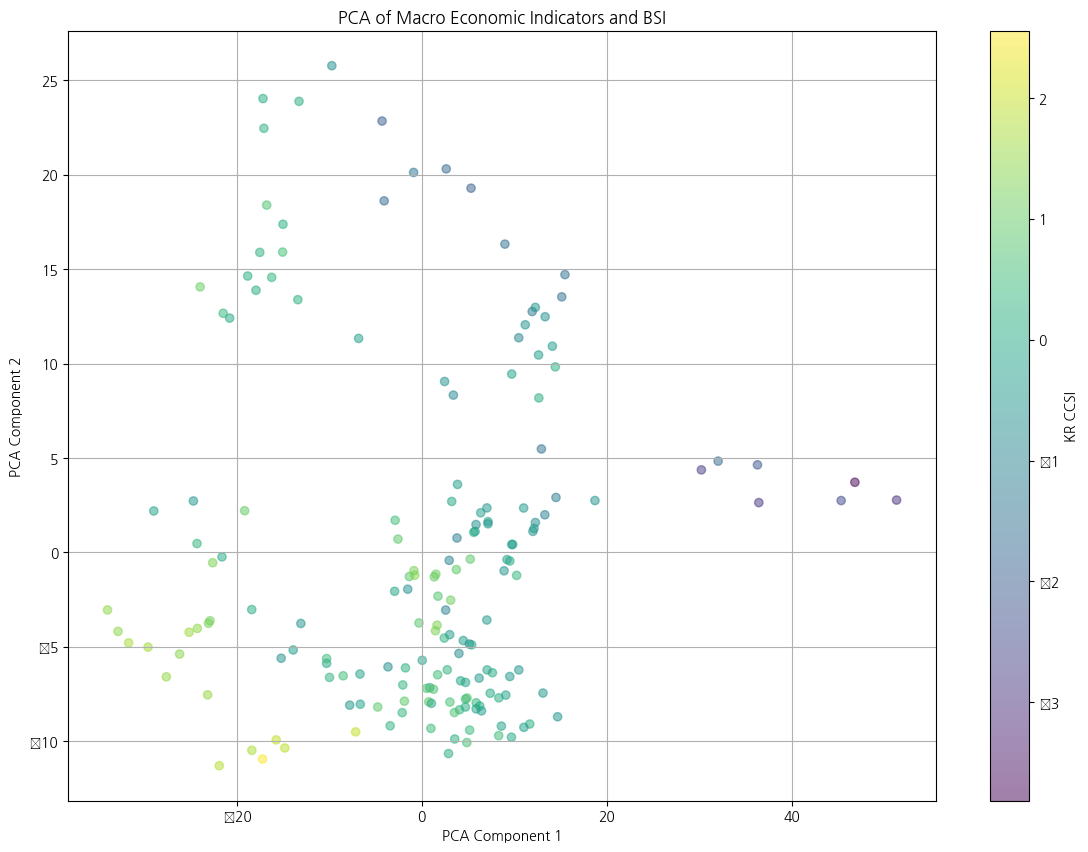

Model Performance
                              R²       MAE
Linear Regression       0.797339  0.061838
Random Forest           0.873595  0.049500
Gradient Boosting       0.902564  0.044090
Support Vector Machine  0.811855  0.062264
Multi-layer Perceptron -1.184506  0.220626


In [7]:
#############################
# 각 업종별 업황실적 / 각 매크로경제지표 간 상관관계 분석
#############################

# PCA(주성분분석)
# [주의: 오래걸림] 5가지의 기계학습 알고리즘 모델을 구축하여 학습시킨 후 성능평가
#               (Linear Regression, Random Forest, Gradient Boosting, Support Vector Machine, Multi-layer Perceptron)
# 최종적으로 Gradient Boosting이 성능이 제일 높음 (R^2 : 설명력 / MAE : 실제값 간 오차값)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import statsmodels.api as sm


# NanumGothic 글꼴 경로
font_path = 'font/NanumGothic.ttf'

# 글꼴 등록
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = fontprop.get_name()

# 데이터 불러오기
macro_file = 'Data/Summary/MacroEconomic.xlsx'
bsi_file = 'Data/Summary/Normalized_BSI_Data.xlsx'

macro_data = pd.read_excel(macro_file)
bsi_data = pd.read_excel(bsi_file)

# 데이터 전처리
macro_data['index'] = pd.to_datetime(macro_data['index'], format='%Y/%m')
bsi_data['업종_BSI'] = bsi_data['업종코드별'] + '_' + bsi_data['BSI코드별']
bsi_data = bsi_data.drop(columns=['업종코드별', 'BSI코드별']).set_index('업종_BSI').transpose()
bsi_data.index = pd.to_datetime(bsi_data.index, format='%Y/%m')

# 데이터 결합
merged_data = macro_data.merge(bsi_data, left_on='index', right_index=True, how='inner')
# 'index' 열이 datetime 형식이라면 문자열로 변환합니다.
merged_data['index_str'] = merged_data['index'].astype(str)
# '2024'가 포함된 행을 제외합니다.
merged_data_filtered = merged_data[~merged_data['index_str'].str.contains('2024')]
# 불필요한 'index_str' 열을 제거합니다.
merged_data = merged_data_filtered.drop(columns=['index_str'])

# EDA
print("EDA Summary Statistics")
print(merged_data.describe())

# 상관관계 분석
macro_columns = macro_data.columns[1:]  # 매크로 경제 지표
bsi_columns = [col for col in merged_data.columns if '업황실적' in col]  # 업황실적 데이터

# 숫자형 데이터만 사용하여 상관관계 분석
numeric_macro_data = merged_data[macro_columns].select_dtypes(include=[np.number])
numeric_bsi_data = merged_data[bsi_columns].select_dtypes(include=[np.number])

correlation_matrix = pd.concat([numeric_macro_data, numeric_bsi_data], axis=1).corr()
macro_bsi_correlation = correlation_matrix.loc[macro_columns, bsi_columns]

# 업종 순서 조정
# macro_bsi_correlation_industry_order = sorted([ind for ind in macro_bsi_correlation.index if ind != '전산업'], reverse=True) + ['전산업']
# normalized_coefficients_df = normalized_coefficients_df.loc[industry_order]

# pcolor를 이용한 히트맵 시각화
plt.figure(figsize=(20, 15))
fig, ax = plt.subplots(figsize=(20, 15))
c = ax.pcolor(macro_bsi_correlation.T, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(c, ax=ax)

# X축 레이블을 위로 이동
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# 축 레이블 설정
ax.set_xticks(np.arange(macro_bsi_correlation.T.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(macro_bsi_correlation.T.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(macro_bsi_correlation.T.columns, minor=False, rotation=45, ha='left', fontsize=12)
ax.set_yticklabels(macro_bsi_correlation.T.index.str.replace("_업황실적",""), minor=False, fontsize=12)

# 각 셀마다 숫자 표시
for i in range(macro_bsi_correlation.T.shape[0]):
    for j in range(macro_bsi_correlation.T.shape[1]):
        ax.text(j + 0.5, i + 0.5, f'{macro_bsi_correlation.T.iloc[i, j]:.2f}', 
                horizontalalignment='center', verticalalignment='center', fontsize=8, color='black')

plt.xlabel('매크로 경제 지표', fontsize=16, fontproperties=font_prop)
plt.ylabel('업황실적', fontsize=16, fontproperties=font_prop)
plt.title("각 업종별 실적 및 매크로 경제 지표 간 상관관계(장기간) ", pad=20)
plt.savefig("picture/3-Correlation macro with bsi.png")
plt.show()

# 회귀분석 예시
def perform_regression(merged_data, macro_column, bsi_column):
    X = merged_data[[macro_column]]
    Y = merged_data[bsi_column]
    
    # 상수항 추가
    X = sm.add_constant(X)
    
    # 회귀분석 모델 적합
    model = sm.OLS(Y, X).fit()
    
    return model.summary()

print(perform_regression(merged_data, 'KR CCSI', '전산업_업황실적'))

# PCA 수행
macro_columns = macro_data.columns[1:]
bsi_columns = [col for col in merged_data.columns if '업황실적' in col]

pca_data = merged_data.drop(columns=['index']).dropna()
scaler = StandardScaler()
pca_data_scaled = scaler.fit_transform(pca_data)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pca_data_scaled)

# 주성분 로딩 값 확인
loadings = pd.DataFrame(pca.components_.T, columns=['PCA Component 1', 'PCA Component 2'], index=pca_data.columns)

# PCA 결과 시각화
plt.figure(figsize=(14, 10))

# 주성분 결과를 시각화
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, c=pca_data_scaled[:, macro_columns.tolist().index('KR CCSI')], cmap='viridis')
plt.colorbar(scatter, label='KR CCSI')

# 중요 지표 라벨 추가
for i in range(loadings.shape[0]):
    if abs(loadings.iloc[i, 0]) > 0.3 or abs(loadings.iloc[i, 1]) > 0.3:  # 중요 지표만 텍스트 표시
        plt.text(loadings.iloc[i, 0]*10, loadings.iloc[i, 1]*10, loadings.index[i], color='red', ha='center', va='center', fontsize=10)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Macro Economic Indicators and BSI')
plt.grid()
plt.savefig("picture/4-PCA of Macro Economic Indicators and BSI.png")
plt.show()

# 모델링 학습 및 평가
X = merged_data[macro_columns]
Y = merged_data['전산업_업황실적']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Machine": SVR(),
    "Multi-layer Perceptron": MLPRegressor(random_state=42, max_iter=500)
}

predictions = {}
for name, model in models.items():
    model.fit(X_train, Y_train)
    predictions[name] = model.predict(X_test)

performance = {}
for name, prediction in predictions.items():
    r2 = r2_score(Y_test, prediction)
    mae = mean_absolute_error(Y_test, prediction)
    performance[name] = {"R²": r2, "MAE": mae}

performance_df = pd.DataFrame(performance).T
print("Model Performance")
print(performance_df)

/var/folders/_x/85c_20bd0yg0yw7bsqgk4qbh0000gp/T/ipykernel_76497/4241762726.py:49: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(c, ax=ax)
/var/folders/_x/85c_20bd0yg0yw7bsqgk4qbh0000gp/T/ipykernel_76497/4241762726.py:70: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig("picture/5-Correlation bsi with bsi.png")


<Figure size 2000x1500 with 0 Axes>

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


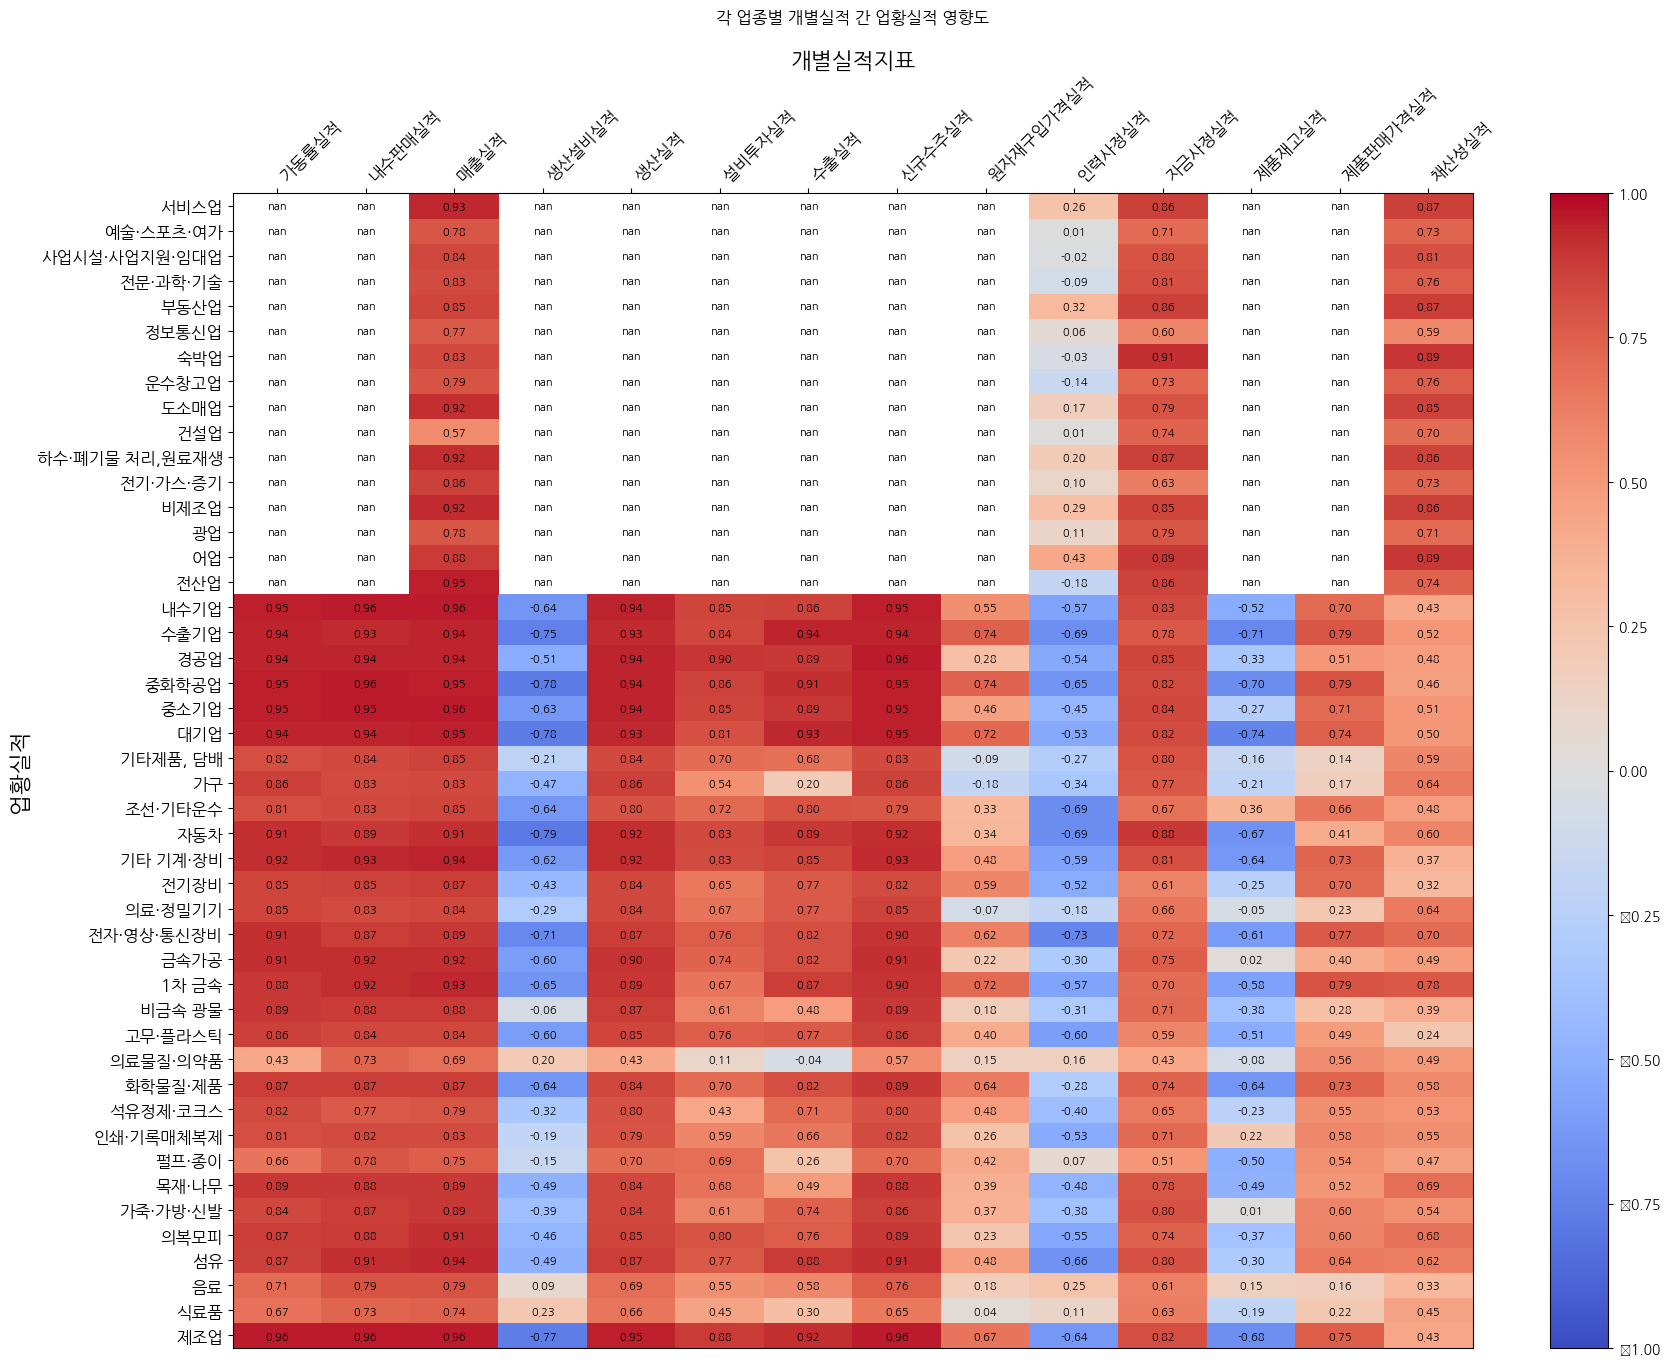

In [28]:
######################################
# 각 업종별 업황실적과 업종별 개별실적지표 간의 상관관계
######################################

import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기
macro_file = 'Data/Summary/MacroEconomic.xlsx'
bsi_file = 'Data/Summary/Normalized_BSI_Data.xlsx'

macro_data = pd.read_excel(macro_file)
bsi_data = pd.read_excel(bsi_file)


# Function to calculate and plot the correlation heatmap with adjustments
def calculate_and_plot_correlation_heatmap(data):
    correlation_dict = {}
    
    # List of unique industry codes
    industry_codes = data['업종코드별'].unique()
    
    for industry_code in industry_codes:
        # Filter the data for the given industry code
        industry_data = data[data['업종코드별'] == industry_code]
        
        # Separate the target "업황실적" and other actuals
        target_actual = industry_data[industry_data['BSI코드별'] == '업황실적'].drop(columns=['업종코드별', 'BSI코드별']).T
        other_actuals = industry_data[industry_data['BSI코드별'] != '업황실적'].drop(columns=['업종코드별']).set_index('BSI코드별').T
        
        # Fill missing values with the mean
        target_actual = target_actual.fillna(target_actual.mean())
        other_actuals = other_actuals.fillna(other_actuals.mean())
        
        # Calculate correlation between the target and each of the other actuals
        correlation_results = other_actuals.corrwith(target_actual.iloc[:, 0], method='pearson')
        
        # Store the results in the dictionary
        correlation_dict[industry_code] = correlation_results
    
    # Convert the dictionary to a DataFrame
    correlation_matrix = pd.DataFrame(correlation_dict)
    
    ########## pcolor
    # pcolor를 이용한 히트맵 시각화
    plt.figure(figsize=(20, 15))
    fig, ax = plt.subplots(figsize=(20, 15))
    c = ax.pcolor(correlation_matrix.T, cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(c, ax=ax)

    # X축 레이블을 위로 이동
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    # 축 레이블 설정
    ax.set_xticks(np.arange(correlation_matrix.T.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(correlation_matrix.T.shape[0]) + 0.5, minor=False)
    ax.set_xticklabels(correlation_matrix.T.columns, minor=False, rotation=45, ha='left', fontsize=12)
    ax.set_yticklabels(correlation_matrix.T.index, minor=False, fontsize=12)

    # 각 셀마다 숫자 표시
    for i in range(correlation_matrix.T.shape[0]):
        for j in range(correlation_matrix.T.shape[1]):
            ax.text(j + 0.5, i + 0.5, f'{correlation_matrix.T.iloc[i, j]:.2f}', 
                    horizontalalignment='center', verticalalignment='center', fontsize=8, color='black')

    plt.xlabel('개별실적지표', fontsize=16, fontproperties=font_prop)
    plt.ylabel('업황실적', fontsize=16, fontproperties=font_prop)
    plt.title("각 업종별 개별실적 간 업황실적 영향도", pad=20)
    plt.savefig("picture/5-Correlation bsi with bsi.png")
    plt.show()

# Calculate and plot the correlation heatmap
calculate_and_plot_correlation_heatmap(bsi_data)

/var/folders/_x/85c_20bd0yg0yw7bsqgk4qbh0000gp/T/ipykernel_33309/4116659576.py:74: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig("picture/6-Correlation macro with macro.png")


<Figure size 2000x1500 with 0 Axes>

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


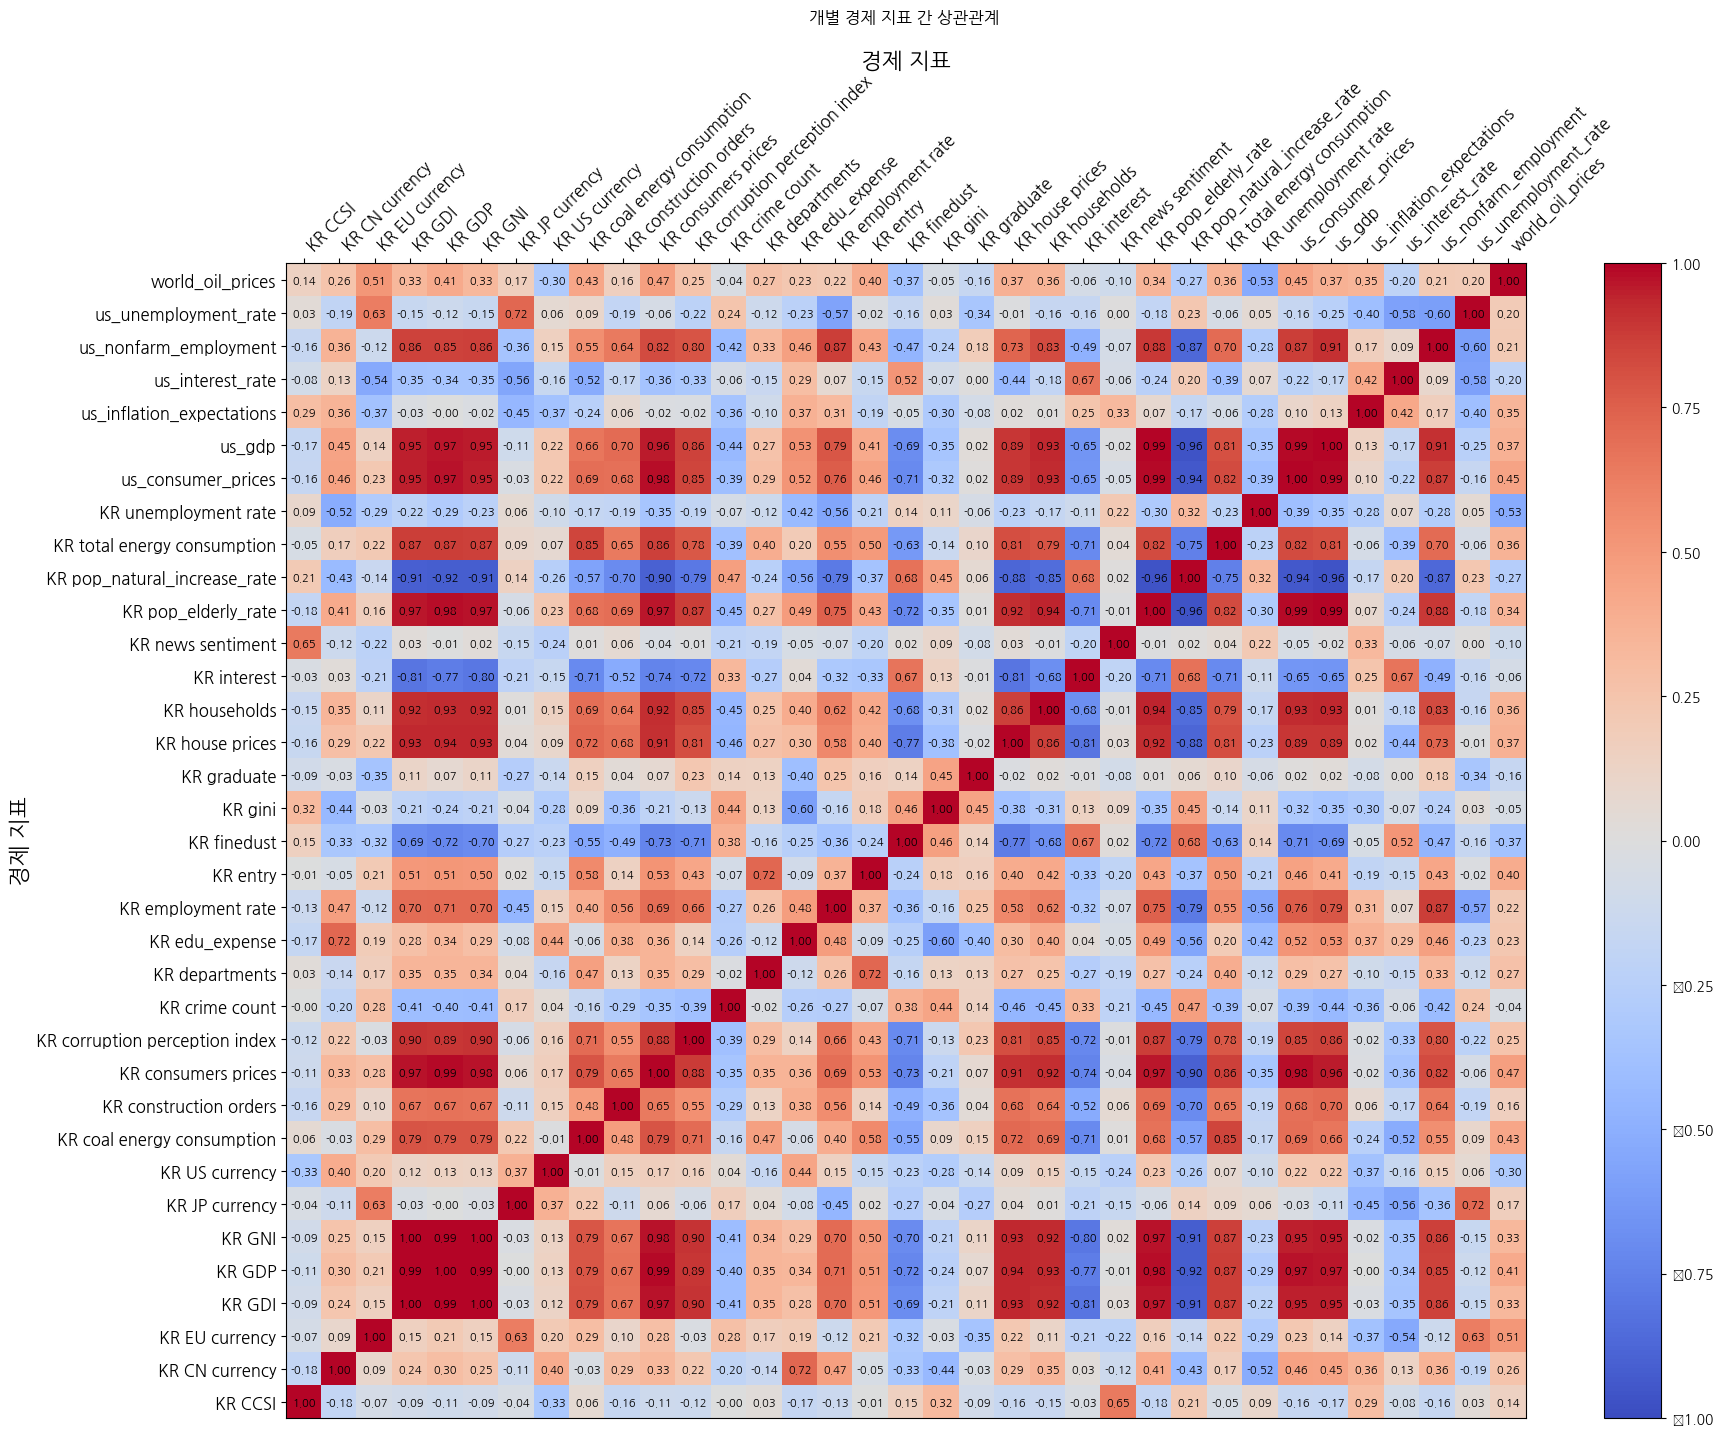

In [49]:
######################################
# 각 매크로 경제 지표 간 상관관계 분석 및 히트맵
######################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import xgboost as xgb  # XGBoost 라이브러리

# NanumGothic 글꼴 경로
font_path = 'font/NanumGothic.ttf'

# 글꼴 등록
fm.fontManager.addfont(font_path)
fontprop = fm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = fontprop.get_name()

# 데이터 불러오기
macro_file = 'Data/Summary/MacroEconomic.xlsx'
bsi_file = 'Data/Summary/Normalized_BSI_Data.xlsx'

macro_data = pd.read_excel(macro_file)
bsi_data = pd.read_excel(bsi_file)


# 데이터 전처리
macro_data['index'] = pd.to_datetime(macro_data['index'], format='%Y/%m')
# 'index' 열이 datetime 형식이라면 문자열로 변환합니다.
macro_data['index_str'] = macro_data['index'].astype(str)
# '2024'가 포함된 행을 제외합니다.
macro_data_filtered = macro_data[~macro_data['index_str'].str.contains('2024')]
# 불필요한 'index_str' 열을 제거합니다.
macro_data = macro_data_filtered.drop(columns=['index_str'])

macro_data = macro_data.set_index('index')


# 숫자형 데이터만 사용하여 상관관계 분석
numeric_macro_data = macro_data.select_dtypes(include=[np.number])
macro_correlation_matrix = numeric_macro_data.corr()

# 상관관계 분석
macro_correlation_matrix = macro_data.corr()

# pcolor를 이용한 히트맵 시각화
plt.figure(figsize=(20, 15))
fig, ax = plt.subplots(figsize=(20, 15))
c = ax.pcolor(macro_correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(c, ax=ax)

# X축 레이블을 위로 이동
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# 축 레이블 설정
ax.set_xticks(np.arange(macro_correlation_matrix.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(macro_correlation_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(macro_correlation_matrix.columns, minor=False, rotation=45, ha='left', fontsize=12)
ax.set_yticklabels(macro_correlation_matrix.index, minor=False, fontsize=12)

# 각 셀마다 숫자 표시
for i in range(macro_correlation_matrix.shape[0]):
    for j in range(macro_correlation_matrix.shape[1]):
        ax.text(j + 0.5, i + 0.5, f'{macro_correlation_matrix.iloc[i, j]:.2f}', 
                horizontalalignment='center', verticalalignment='center', fontsize=8, color='black')

plt.xlabel('경제 지표', fontsize=16, fontproperties=fontprop)
plt.ylabel('경제 지표', fontsize=16, fontproperties=fontprop)
plt.title("개별 경제 지표 간 상관관계 ", pad=20)
plt.savefig("picture/6-Correlation macro with macro.png")
plt.show()

In [314]:
#############################
#LSTM(딥러닝 인공신경망 알고리즘) 모델링 샘플
#############################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# NanumGothic 글꼴 경로
font_path = 'font/NanumGothic.ttf'

# 글꼴 등록
fm.fontManager.addfont(font_path)
fontprop = fm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = fontprop.get_name()

# 데이터 불러오기
macro_file = 'Data/Summary/MacroEconomic.xlsx'
bsi_file = 'Data/Summary/Normalized_BSI_Data.xlsx'

macro_data = pd.read_excel(macro_file)
bsi_data = pd.read_excel(bsi_file)

macro_data['index'] = pd.to_datetime(macro_data['index'], format='%Y/%m')
bsi_data['업종_BSI'] = bsi_data['업종코드별'] + '_' + bsi_data['BSI코드별']
bsi_data = bsi_data.drop(columns=['업종코드별', 'BSI코드별']).set_index('업종_BSI').transpose()
bsi_data.index = pd.to_datetime(bsi_data.index, format='%Y/%m')

# 데이터 결합
merged_data = macro_data.merge(bsi_data, left_on='index', right_index=True, how='inner')
# 'index' 열이 datetime 형식이라면 문자열로 변환합니다.
merged_data['index_str'] = merged_data['index'].astype(str)
# '2024'가 포함된 행을 제외합니다.
merged_data_filtered = merged_data[~merged_data['index_str'].str.contains('2024')]
# 불필요한 'index_str' 열을 제거합니다.
merged_data = merged_data_filtered.drop(columns=['index_str'])

macro_columns = macro_data.columns[1:]
bsi_columns = [col for col in merged_data.columns if '업황실적' in col]

X = merged_data[macro_columns].values
Y = merged_data['전산업_업황실적'].values

# 데이터 정규화
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y.reshape(-1, 1))

# 시계열 데이터 형태로 변환
def create_dataset(X, Y, time_steps=1):
    Xs, Ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        Ys.append(Y[i + time_steps])
    return np.array(Xs), np.array(Ys)

time_steps = 3
X_ts, Y_ts = create_dataset(X_scaled, Y_scaled, time_steps)

# 데이터 분할
X_train, X_test, Y_train, Y_test = train_test_split(X_ts, Y_ts, test_size=0.2, random_state=42)

# LSTM 모델 구축
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_steps, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# 모델 학습
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# 모델 저장
model.save('model/lstm_model.h5')

# 모델 성능 평가
Y_pred_scaled = model.predict(X_test)
Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
Y_test = scaler_Y.inverse_transform(Y_test)

lstm_rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

print("LSTM Model Performance")
print(f"RMSE: {lstm_rmse:.4f}")

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 3, 100)         │        54,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 3, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,851 (659.57 KB)

 Trainable params: 168,851 (659.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 226ms/step - loss: 0.3404 - val_loss: 0.3051
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2438 - val_loss: 0.1878
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1437 - val_loss: 0.0388
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0667 - val_loss: 0.0449
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0689 - val_loss: 0.0211
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0401 - val_loss: 0.0361
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0400 - val_loss: 0.0321
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0366 - val_loss: 0.0165
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0347 - val_loss: 0.0131
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0372 - val_loss: 0.0125
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0334 - val_loss: 0.0186
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0315 - val_loss: 0.0179


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/stepWARNING:tensorflow:6 out of the last 7 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x1a8b1a7a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
LSTM Model Performance
RMSE: 0.0926


Fitting 3 folds for each of 243 candidates, totalling 729 fits
XGBoost Model Performance
R²: 0.9382
MAE: 0.0384


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - loss: 0.3309 - val_loss: 0.2470
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1868 - val_loss: 0.0700
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0648 - val_loss: 0.0490
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0772 - val_loss: 0.0170
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0419 - val_loss: 0.0366
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0462 - val_loss: 0.0377
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0430 - val_loss: 0.0168
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0287 - val_loss: 0.0100
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0278 - val_loss: 0.0098
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0265 - val_loss: 0.0185
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0298 - val_loss: 0.0186
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0259 - val_loss: 0.0106


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 494ms/step


LSTM Model Performance
RMSE: 0.1130
Example Predictions with XGBoost for Future Data:
[0.6794756 0.6794756 0.6618635 0.6794756 0.6618635]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
Example Predictions with LSTM for Future Data:
[[0.0084633 ]
 [0.0084633 ]
 [0.00846329]]


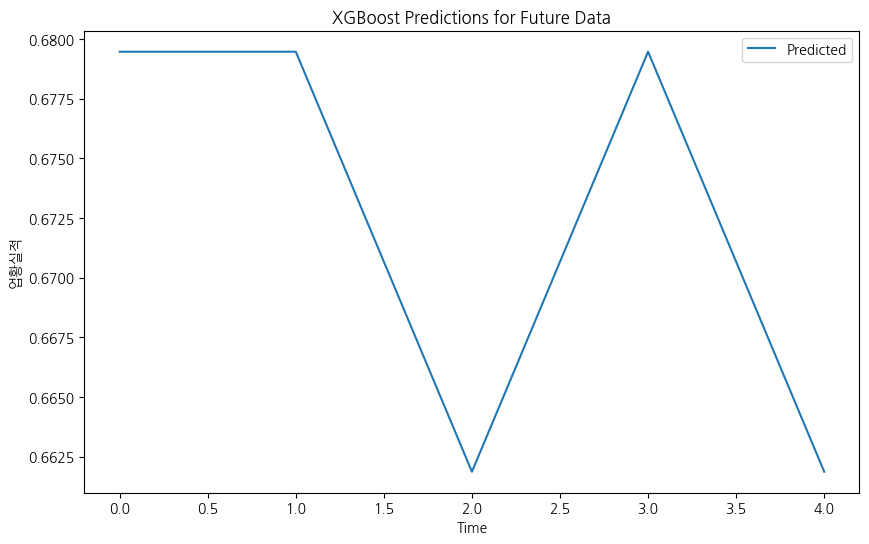

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


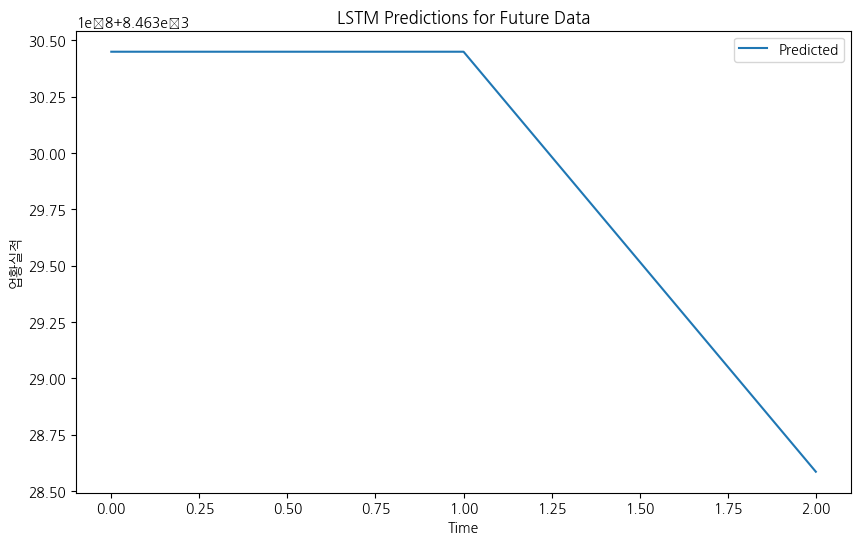

In [324]:
# XGBoost와 LSTM 모델 간 실제 데이터를 잘 예측하는 지 시각화로 평가

#################################
# 리스크 관리 모델 구축(수집/전처리 - 예측모델학습저장 - 모델구축 - 시각화 및 리포팅)
#################################

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 데이터 불러오기
macro_file = 'Data/Summary/MacroEconomic.xlsx'
bsi_file = 'Data/Summary/Normalized_BSI_Data.xlsx'

macro_data = pd.read_excel(macro_file)
bsi_data = pd.read_excel(bsi_file)

# 데이터 전처리
macro_data['index'] = pd.to_datetime(macro_data['index'], format='%Y/%m')
bsi_data['업종_BSI'] = bsi_data['업종코드별'] + '_' + bsi_data['BSI코드별']
bsi_data = bsi_data.drop(columns=['업종코드별', 'BSI코드별']).set_index('업종_BSI').transpose()
bsi_data.index = pd.to_datetime(bsi_data.index, format='%Y/%m')

# 데이터 결합
merged_data = macro_data.merge(bsi_data, left_on='index', right_index=True, how='inner')
# 'index' 열이 datetime 형식이라면 문자열로 변환합니다.
merged_data['index_str'] = merged_data['index'].astype(str)
# '2024'가 포함된 행을 제외합니다.
merged_data_filtered = merged_data[~merged_data['index_str'].str.contains('2024')]
# 불필요한 'index_str' 열을 제거합니다.
merged_data = merged_data_filtered.drop(columns=['index_str'])


#######################
# 예측모델 학습 및 저장(XGBoost)
#######################
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_absolute_error
import joblib

# XGBoost 모델 학습 및 저장 함수
def train_and_save_xgboost_model(X, Y, model_path='model/xgboost_model.pkl'):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    # 하이퍼파라미터 튜닝(정규화 포함)
    # GridSearch 방식 하이퍼파라미터
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [2, 3, 4],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'reg_alpha': [0.0, 0.1, 0.5],  # L1 정규화
        'reg_lambda': [1.0, 1.5, 2.0]  # L2 정규화
    }

    # 베이시안 방식 하이퍼파라미터
    param_space = {
        'n_estimators': (50, 500),
        'learning_rate': (0.01, 0.1),
        'max_depth': (3, 10),
        'subsample': (0.6, 1.0),
        'colsample_bytree': (0.6, 1.0),
        'reg_alpha': (0.0, 1.0),  # L1 정규화
        'reg_lambda': (1.0, 2.0)  # L2 정규화
    }
    
    # XGBoost 모델 학습
    xgboost_model = xgb.XGBRegressor(random_state=42)

    # GridSearch 모델링
    #grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, cv=3, scoring='r2', verbose=1)
    #grid_search.fit(X_train, Y_train)
    # best_model = grid_search.best_estimator_

    # 베이시안 모델링
    opt = BayesSearchCV(
        estimator=xgboost_model,
        search_spaces=param_space,
        cv=3,
        n_iter=50,
        scoring='r2',
        random_state=42,
        verbose=1
    )
    opt.fit(X_train, Y_train)
    best_model = opt.best_estimator_    

    # 모델 저장
    joblib.dump(best_model, model_path)
    
    # 모델 성능 평가
    predictions = best_model.predict(X_test)
    r2 = r2_score(Y_test, predictions)
    mae = mean_absolute_error(Y_test, predictions)
    
    print("XGBoost Model Performance")
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print()

    # 교차 검증 수행(과적합 방지)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cross_val_r2_scores = cross_val_score(best_model, X, Y, cv=kfold, scoring='r2')
    cross_val_mae_scores = cross_val_score(best_model, X, Y, cv=kfold, scoring='neg_mean_absolute_error')
    
    print("Cross-Validation Performance")
    print(f"Mean Cross-Validation R²: {cross_val_r2_scores.mean():.4f}")
    print(f"Mean Cross-Validation MAE: {-cross_val_mae_scores.mean():.4f}")
    
    return best_model


macro_columns = macro_data.columns[1:]
bsi_columns = [col for col in merged_data.columns if '업황실적' in col]

X = merged_data[macro_columns]
Y = merged_data['전산업_업황실적']

xgboost_model = train_and_save_xgboost_model(X, Y)


#######################
# 예측모델 학습 및 저장(LSTM)
#######################
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error
import numpy as np

X = merged_data[macro_columns].values
Y = merged_data['전산업_업황실적'].values

# 데이터 정규화
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y.reshape(-1, 1))

# 시계열 데이터 형태로 변환
def create_dataset(X, Y, time_steps=1):
    Xs, Ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        Ys.append(Y[i + time_steps])
    return np.array(Xs), np.array(Ys)

time_steps = 3
X_ts, Y_ts = create_dataset(X_scaled, Y_scaled, time_steps)

# 데이터 분할
X_train, X_test, Y_train, Y_test = train_test_split(X_ts, Y_ts, test_size=0.2, random_state=42)


# LSTM 모델 학습 및 저장 함수
def train_and_save_lstm_model(X_train, Y_train, model_path='model/lstm_model.h5'):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(time_steps, X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))


    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)
    
    # 모델 저장
    model.save(model_path)
    return model


lstm_model = train_and_save_lstm_model(X_train, Y_train)

# 모델 성능 평가
Y_pred_scaled = lstm_model.predict(X_test)
Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
Y_test = scaler_Y.inverse_transform(Y_test)

lstm_rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print("LSTM Model Performance")
print(f"RMSE: {lstm_rmse:.4f}")


#######################
# 리스크 관리 모델 구축
#######################
# XGBoost 예측 함수
def predict_new_data_xgboost(new_data, model_path='model/xgboost_model.pkl'):
    model = joblib.load(model_path)
    return model.predict(new_data)

# LSTM 예측 함수
def predict_new_data_lstm(new_data, model_path='model/lstm_model.h5', scaler_X=None, scaler_Y=None, time_steps=3):
    model = load_model(model_path)
    new_data_scaled = scaler_X.transform(new_data)
    
    # 시계열 데이터 형태로 변환
    X_new = []
    for i in range(len(new_data_scaled) - time_steps + 1):
        X_new.append(new_data_scaled[i:i + time_steps])
    X_new = np.array(X_new)
    
    # 예측
    Y_pred_scaled = model.predict(X_new)
    Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
    return Y_pred

# 미래의 테스트용 매크로 데이터 (예시)
future_macro_data = pd.DataFrame({
    'KR CCSI': [100, 102, 104, 106, 108],
    'KR CN currency': [0.15, 0.16, 0.14, 0.15, 0.14],
    'KR EU currency': [0.85, 0.84, 0.83, 0.82, 0.81],
    'KR GDI': [1200, 1250, 1230, 1280, 1300],
    'KR GDP': [1100, 1120, 1130, 1140, 1150],
    'KR GNI': [1150, 1170, 1160, 1180, 1190],
    'KR JP currency': [0.20, 0.21, 0.19, 0.20, 0.19],
    'KR US currency': [1.00, 1.01, 1.02, 1.03, 1.04],
    'KR coal energy consumption': [500, 510, 505, 515, 520],
    'KR construction orders': [300, 320, 310, 330, 340],
    'KR consumers prices': [105, 106, 107, 108, 109],
    'KR corruption perception index': [45, 46, 44, 45, 46],
    'KR crime count': [10000, 10200, 10100, 10300, 10400],
    'KR departments': [150, 155, 152, 157, 160],
    'KR edu_expense': [400, 410, 405, 420, 430],
    'KR employment rate': [70, 72, 71, 73, 74],
    'KR entry': [50, 52, 51, 53, 54],
    'KR finedust': [80, 82, 81, 83, 85],
    'KR gini': [0.35, 0.36, 0.34, 0.35, 0.36],
    'KR graduate': [200, 205, 203, 208, 210],
    'KR house prices': [900, 910, 905, 920, 930],
    'KR households': [5000, 5050, 5025, 5100, 5150],
    'KR interest': [2.5, 2.6, 2.55, 2.65, 2.7],
    'KR news sentiment': [60, 62, 61, 63, 64],
    'KR pop_elderly_rate': [15, 15.2, 15.1, 15.3, 15.4],
    'KR pop_natural_increase_rate': [1, 1.1, 1.05, 1.2, 1.3],
    'KR total energy consumption': [1000, 1010, 1005, 1020, 1030],
    'KR unemployment rate': [5, 5.1, 5.05, 5.2, 5.3],
    'us_consumer_prices': [110, 112, 111, 113, 114],
    'us_gdp': [18000, 18200, 18100, 18300, 18500],
    'us_inflation_expectations': [2.0, 2.1, 2.05, 2.2, 2.3],
    'us_interest_rate': [1.5, 1.6, 1.55, 1.65, 1.7],
    'us_nonfarm_employment': [150000, 151000, 150500, 152000, 153000],
    'us_unemployment_rate': [4.0, 4.1, 4.05, 4.2, 4.3],
    'world_oil_prices': [70, 71, 70.5, 72, 73]
})

# XGBoost 모델을 사용한 예측
xgboost_predictions = predict_new_data_xgboost(future_macro_data, 'model/xgboost_model.pkl')
print("Example Predictions with XGBoost for Future Data:")
print(xgboost_predictions)

# LSTM 모델을 사용한 예측
lstm_predictions = predict_new_data_lstm(future_macro_data.values, 'model/lstm_model.h5', scaler_X, scaler_Y)
print("Example Predictions with LSTM for Future Data:")
print(lstm_predictions)


#######################
# 시각화 및 모니터링
#######################
import matplotlib.pyplot as plt

# 예측 결과 시각화
def plot_predictions(predictions, title):
    plt.figure(figsize=(10, 6))
    plt.plot(predictions, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('업황실적')
    plt.legend()
    plt.show()

plot_predictions(xgboost_predictions, "XGBoost Predictions for Future Data")
plot_predictions(lstm_predictions, "LSTM Predictions for Future Data")


In [13]:
#############################
#XGBoost(기게학습 알고리즘) 모델링 샘플
#############################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb  # XGBoost 라이브러리
from skopt import BayesSearchCV
import joblib 

# NanumGothic 글꼴 경로
font_path = 'font/NanumGothic.ttf'

# 글꼴 등록
fm.fontManager.addfont(font_path)
fontprop = fm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = fontprop.get_name()

# 데이터 불러오기
macro_file = 'Data/Summary/MacroEconomic.xlsx'
bsi_file = 'Data/Summary/Normalized_BSI_Data.xlsx'

macro_data = pd.read_excel(macro_file)
bsi_data = pd.read_excel(bsi_file)

macro_data['index'] = pd.to_datetime(macro_data['index'], format='%Y/%m')
bsi_data['업종_BSI'] = bsi_data['업종코드별'] + '_' + bsi_data['BSI코드별']
bsi_data = bsi_data.drop(columns=['업종코드별', 'BSI코드별']).set_index('업종_BSI').transpose()
bsi_data.index = pd.to_datetime(bsi_data.index, format='%Y/%m')

# 데이터 결합
merged_data = macro_data.merge(bsi_data, left_on='index', right_index=True, how='inner')
# 'index' 열이 datetime 형식이라면 문자열로 변환합니다.
merged_data['index_str'] = merged_data['index'].astype(str)
# '2024'가 포함된 행을 제외합니다.
merged_data_filtered = merged_data[~merged_data['index_str'].str.contains('2024')]
# 불필요한 'index_str' 열을 제거합니다.
merged_data = merged_data_filtered.drop(columns=['index_str'])


macro_columns = macro_data.columns[1:]
bsi_columns = [col for col in merged_data.columns if '업황실적' in col]

X = merged_data[macro_columns]
Y = merged_data['전산업_업황실적']

# 데이터 스케일링 (정규화)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# 하이퍼파라미터 튜닝(정규화 포함)
# GridSearch 방식 하이퍼파라미터
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'reg_alpha': [0.0, 0.1, 0.5],  # L1 정규화
    'reg_lambda': [1.0, 1.5, 2.0]  # L2 정규화
}

# 베이시안 방식 하이퍼파라미터
param_space = {
    'n_estimators': (50, 1000),
    'learning_rate': (0.001, 0.1),
    'max_depth': (3, 15),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'reg_alpha': (0.0, 1.0),  # L1 정규화
    'reg_lambda': (1.0, 10.0)  # L2 정규화
}
    
# XGBoost 모델 학습
xgboost_model = xgb.XGBRegressor(random_state=42)

# GridSearch 모델링
#grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, cv=3, scoring='r2', verbose=1)
#grid_search.fit(X_train, Y_train)
# best_model = grid_search.best_estimator_

# 베이시안 모델링
opt = BayesSearchCV(
        estimator=xgboost_model,
        search_spaces=param_space,
        cv=5,
        n_iter=100,
        scoring='r2',
        random_state=42,
        verbose=0
    )
opt.fit(X_train, Y_train)
best_model = opt.best_estimator_    


# 모델 저장
joblib.dump(best_model, 'model/xgboost_model.pkl')

# 모델 성능 평가
xgboost_predictions = best_model.predict(X_test)
xgboost_r2 = r2_score(Y_test, xgboost_predictions)
xgboost_mae = mean_absolute_error(Y_test, xgboost_predictions)
xgboost_rmse = np.sqrt(mean_squared_error(Y_test, xgboost_predictions))

print("XGBoost Model Performance")
print(f"R²: {xgboost_r2:.4f}")
print(f"MAE: {xgboost_mae:.4f}")
print(f"RMSE: {xgboost_rmse:.4f}")
print()


# 이진 분류로 변환을 위한 임계값 설정 (예: 중간값 기준)
threshold = np.median(Y_train)
Y_test_binary = (Y_test > threshold).astype(int)
xgboost_predictions_binary = (xgboost_predictions > threshold).astype(int)

# 이진 분류 성능 평가
recall = recall_score(Y_test_binary, xgboost_predictions_binary)
f1 = f1_score(Y_test_binary, xgboost_predictions_binary)

print("Binary Classification Performance")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print()

# 교차 검증 수행(과적합 방지)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
cross_val_r2_scores = cross_val_score(best_model, X, Y, cv=kfold, scoring='r2')
cross_val_mae_scores = cross_val_score(best_model, X, Y, cv=kfold, scoring='neg_mean_absolute_error')
cross_val_rmse_scores = cross_val_score(best_model, X, Y, cv=kfold, scoring='neg_root_mean_squared_error')

# 이진 분류 성능을 위한 교차 검증
def binary_cross_val_score(estimator, X, y, cv, scoring):
    scores = []
    threshold = np.median(y)
    y_binary = (y > threshold).astype(int).reset_index(drop=True)
    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        y_pred_binary = (y_pred > threshold).astype(int)
        if scoring == 'recall':
            score = recall_score(y_test, y_pred_binary)
        elif scoring == 'f1':
            score = f1_score(y_test, y_pred_binary)
        scores.append(score)
    return np.array(scores)

cross_val_recall_scores = binary_cross_val_score(best_model, X, Y, cv=kfold, scoring='recall')
cross_val_f1_scores = binary_cross_val_score(best_model, X, Y, cv=kfold, scoring='f1')

print("Cross-Validation Performance")
print(f"Mean Cross-Validation R²: {cross_val_r2_scores.mean():.4f}")
print(f"Mean Cross-Validation MAE: {-cross_val_mae_scores.mean():.4f}")
print(f"Mean Cross-Validation RMSE: {-cross_val_rmse_scores.mean():.4f}")
print(f"Mean Cross-Validation Recall: {cross_val_recall_scores.mean():.4f}")
print(f"Mean Cross-Validation F1-Score: {cross_val_f1_scores.mean():.4f}")

XGBoost Model Performance
R²: 0.9075
MAE: 0.0455
RMSE: 0.0545

Binary Classification Performance
Recall: 0.9500
F1-Score: 0.8837

Cross-Validation Performance
Mean Cross-Validation R²: 0.8955
Mean Cross-Validation MAE: 0.0418
Mean Cross-Validation RMSE: 0.0512
Mean Cross-Validation Recall: 0.8690
Mean Cross-Validation F1-Score: 0.8990


In [ ]:
#
######### XGBoost Model Performance ############
#R² (결정 계수) : 0.9075(90.75%)
#해석: 결정 계수는 모델이 전체 변동성의 몇 퍼센트를 설명하는지를 나타냅니다. 
#      0.9075이라는 값은 약 90.75%의 변동성을 설명하고 있음을 의미합니다. 
#      일반적으로 R² 값이 1에 가까울수록 모델의 성능이 좋다고 판단할 수 있습니다.
#        이 값은 상당히 높은 편으로, 모델이 데이터를 잘 설명하고 있음을 나타냅니다.
#
#MAE (평균 절대 오차) : 0.0455(4.55%)
#해석: MAE는 예측값과 실제값 간의 절대 오차의 평균을 나타냅니다.
#    0.0455이라는 값은 모델의 예측이 실제값과 평균적으로 0.0455 정도 차이가 난다는 것을 의미합니다. 
#    값이 낮을수록 모델의 예측이 더 정확함을 나타냅니다.
#
#RMSE (평균 제곱근 오차) : 0.0545(5.45%)
#해석: RMSE는 예측값과 실제값 간의 제곱된 오차의 평균의 제곱근을 나타냅니다. 
#    0.0545이라는 값은 모델의 예측이 실제값과 평균적으로 0.0545 정도 차이가 난다는 것을 의미합니다. 
#    RMSE는 MAE보다 큰 오차에 더 민감하게 반응하므로, MAE와 함께 해석할 때 유용합니다. 
#    이 값 또한 낮을수록 모델의 예측이 더 정확함을 나타냅니다.
#
#
######### Binary Classification Performance #########
#Recall (재현율) : 0.95(95%)
#해석: 재현율은 실제로 긍정 클래스인 것 중 모델이 맞게 예측한 비율을 나타냅니다. 
#    0.9500이라는 값은 모델이 실제 긍정 클래스의 90%를 올바르게 예측했다는 것을 의미합니다. 
#    재현율이 높을수록 모델이 실제 긍정 클래스를 놓치지 않고 잘 예측하고 있음을 나타냅니다.
#
#F1-Score: 0.8837(88.37%)
#해석: F1-Score는 정밀도(Precision)와 재현율(Recall)의 조화 평균입니다. 
#    0.8837라는 값은 모델이 예측의 정확성과 재현율의 균형을 잘 맞추고 있음을 의미합니다. 
#    F1-Score는 두 지표 간의 균형을 고려하기 때문에, 둘 중 하나가 매우 낮은 경우 이를 반영하여 더 현실적인 평가를 제공합니다.
#
#
######### Cross-Validation Performance #########
#Mean Cross-Validation R²: 0.8955
#해석: 교차 검증을 통해 계산된 평균 R² 값입니다. 
#    모델이 다른 데이터셋에서도 일관되게 약 88.45%의 변동성을 설명하고 있음을 의미합니다. 
#    이는 모델의 일반화 성능이 좋음을 나타냅니다.
#
#Mean Cross-Validation MAE: 0.0418
#해석: 교차 검증을 통해 계산된 평균 MAE 값입니다. 
#    모델의 예측이 다른 데이터셋에서도 평균적으로 0.0474 정도 차이가 난다는 것을 의미합니다. 
#    이는 모델의 일관된 예측 정확성을 나타냅니다.
#
#Mean Cross-Validation RMSE: 0.0512
#해석: 교차 검증을 통해 계산된 평균 RMSE 값입니다. 
#    모델의 예측이 다른 데이터셋에서도 평균적으로 0.0601 정도 차이가 난다는 것을 의미합니다. 
#    이는 모델의 일관된 예측 정확성을 나타냅니다.
#
#Mean Cross-Validation Recall : 0.8690
#해석: 교차 검증을 통해 계산된 평균 Recall 값입니다. 
#    모델이 다른 데이터셋에서도 일관되게 실제 긍정 클래스의 약 88.55%를 올바르게 예측하고 있음을 의미합니다.
#
#Mean Cross-Validation F1-Score: 0.8990
#해석: 교차 검증을 통해 계산된 평균 F1-Score 값입니다. 
#    모델이 다른 데이터셋에서도 정밀도와 재현율의 균형을 잘 유지하고 있음을 나타냅니다.
#
#
################## 종합 해석 ##################
#    - 회귀 성능: R² 값이 높고, MAE와 RMSE 값이 낮아 모델의 회귀 성능이 매우 좋습니다. 
#        모델이 전체 데이터의 변동성을 잘 설명하고, 예측 오차도 적음을 의미합니다.
#    - 이진 분류 성능: Recall과 F1-Score 값이 높아 모델의 이진 분류 성능도 우수합니다. 
#        특히 재현율이 높아 실제 긍정 클래스를 잘 예측하고 있으며, F1-Score가 높아 정밀도와 재현율 간의 균형이 잘 맞춰져 있음을 나타냅니다.
#    - 일반화 성능: 교차 검증 결과를 통해 모델이 새로운 데이터셋에서도 일관된 성능을 보임을 확인할 수 있습니다.
#        결론적으로, 모델의 성능이 매우 우수하며, 다양한 지표를 통해 평가한 결과 일관된 성능을 보이고 있습니다. 
#        이 모델은 회귀 및 이진 분류 모두에서 높은 정확도를 제공하며, 실제 데이터에서도 잘 동작할 것으로 기대할 수 있습니다.
#

/var/folders/_x/85c_20bd0yg0yw7bsqgk4qbh0000gp/T/ipykernel_10271/3703285319.py:37: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig("picture/7-1-Learning Curve for XGBoost.png")


<Figure size 1000x500 with 0 Axes>

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


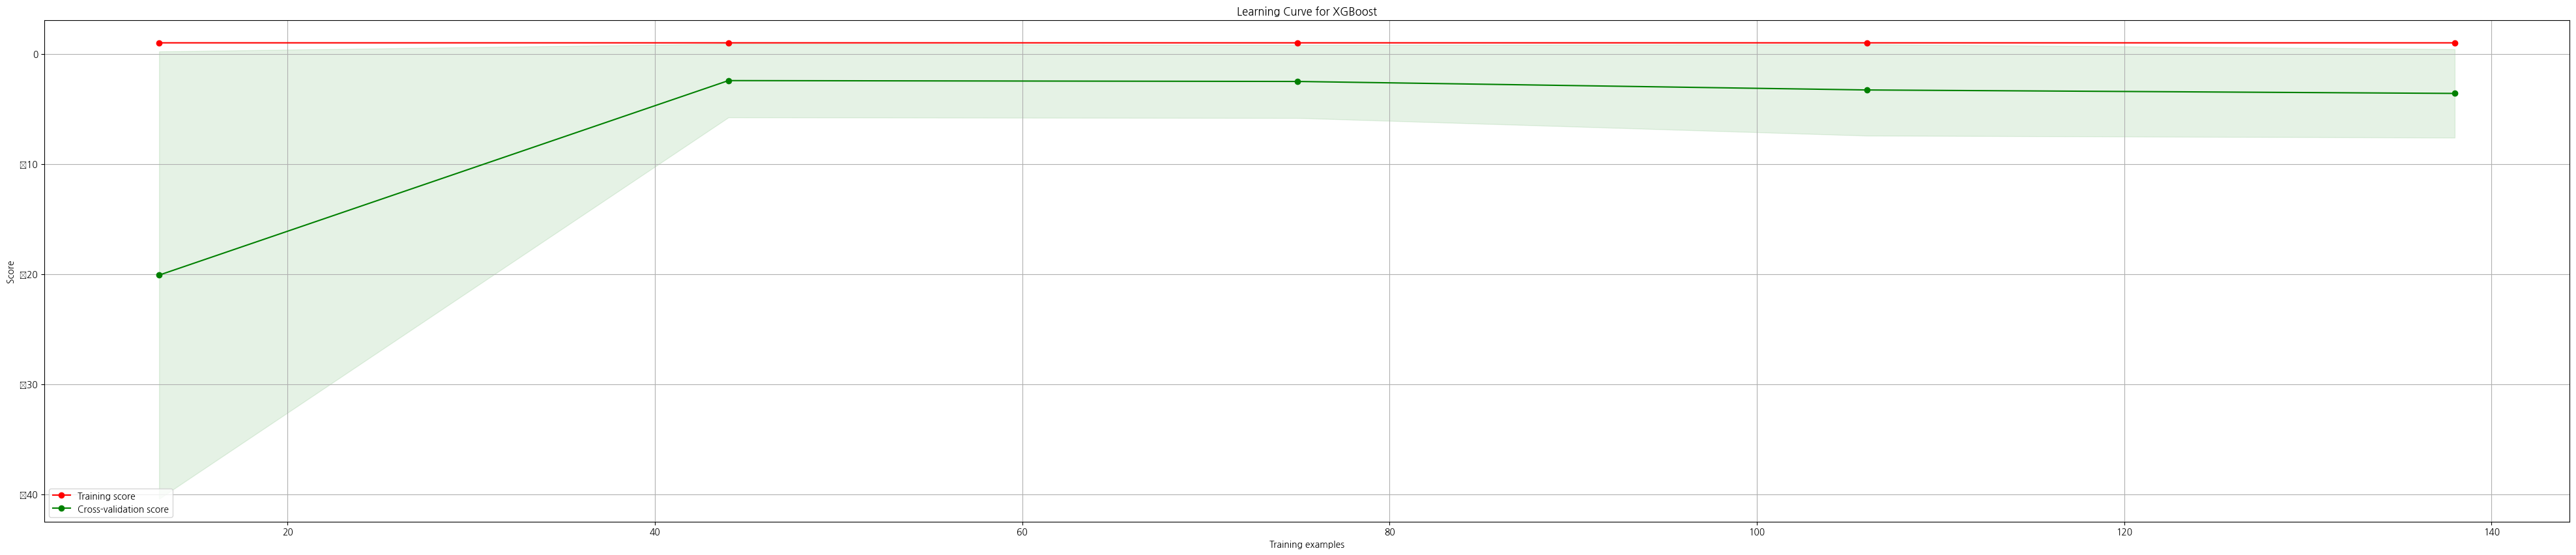

<Figure size 1000x500 with 0 Axes>

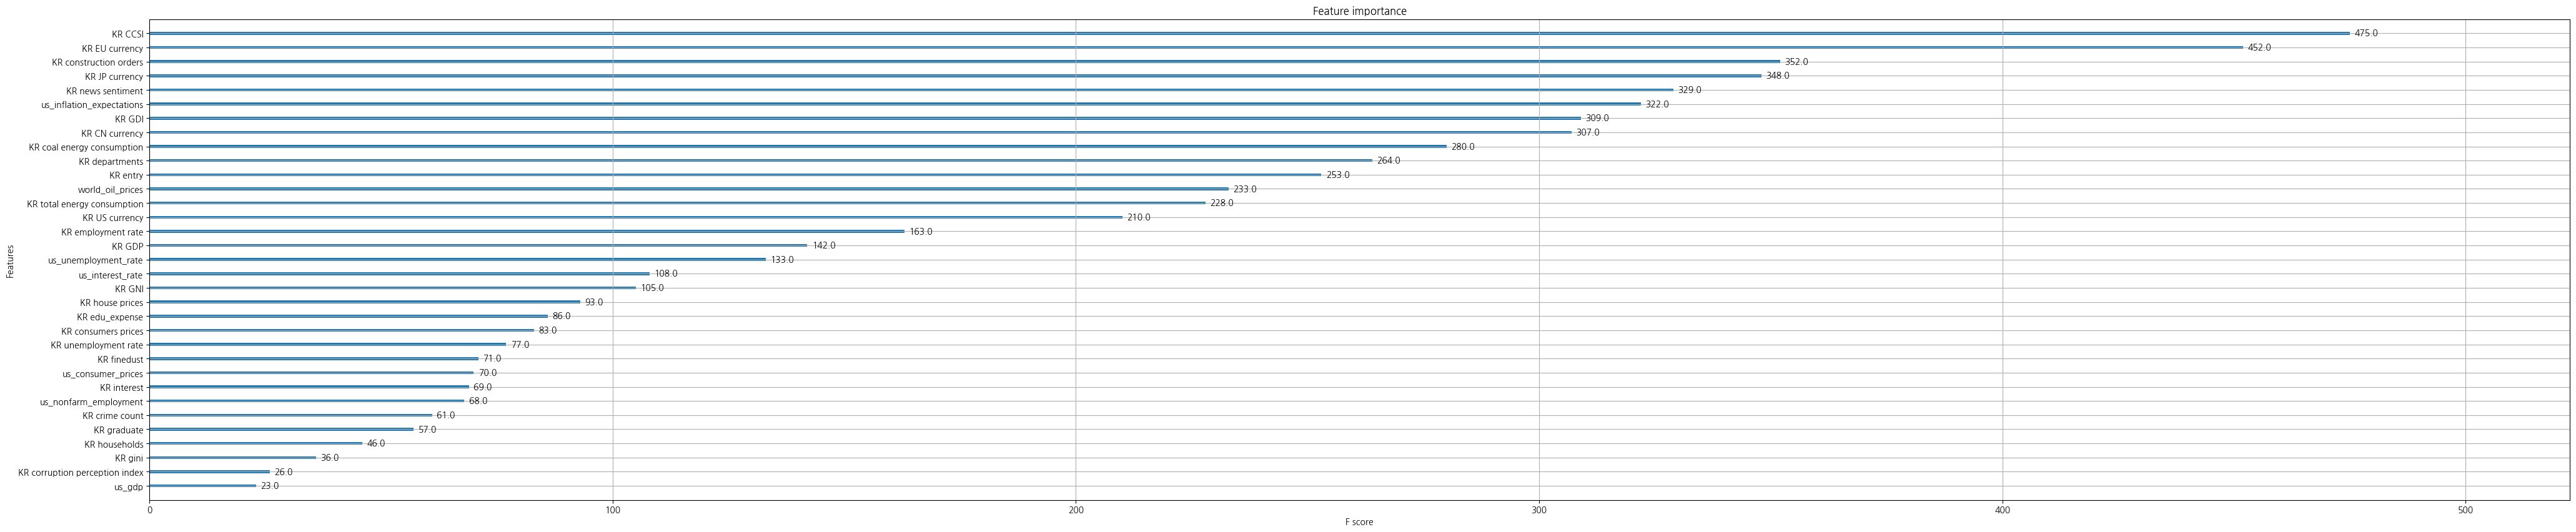

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/_x/85c_20bd0yg0yw7bsqgk4qbh0000gp/T/ipykernel_10271/3703285319.py:74: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig("picture/7-3-Residuals.png")
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


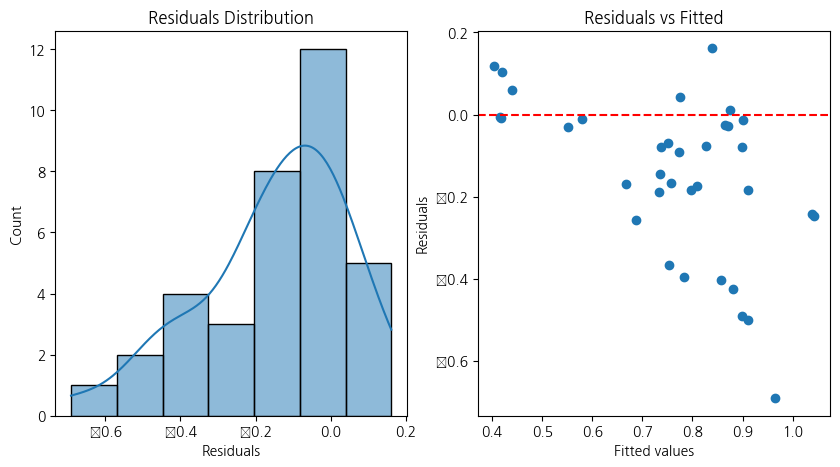

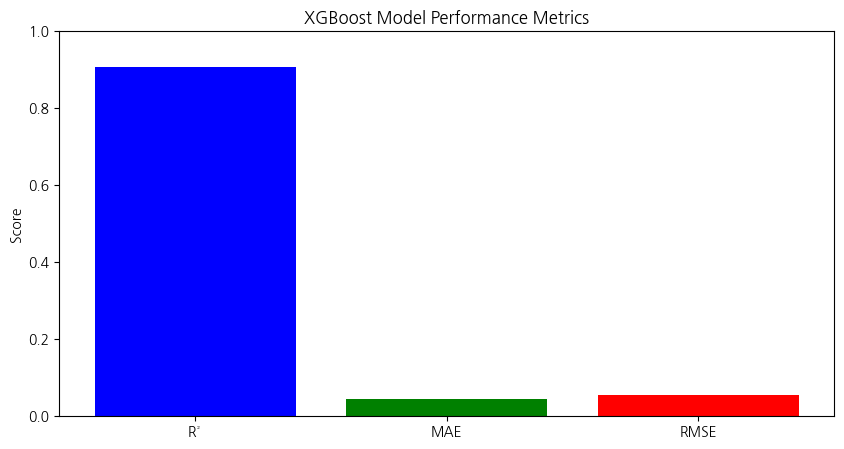

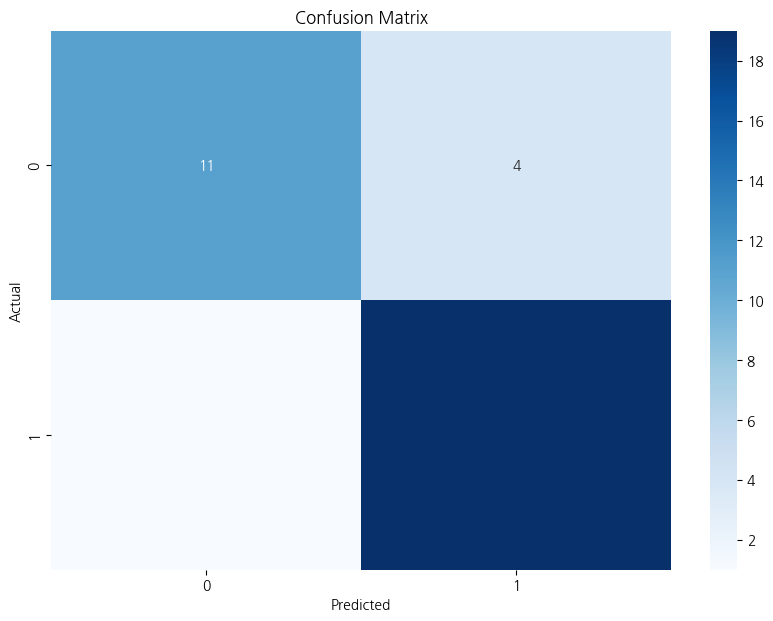

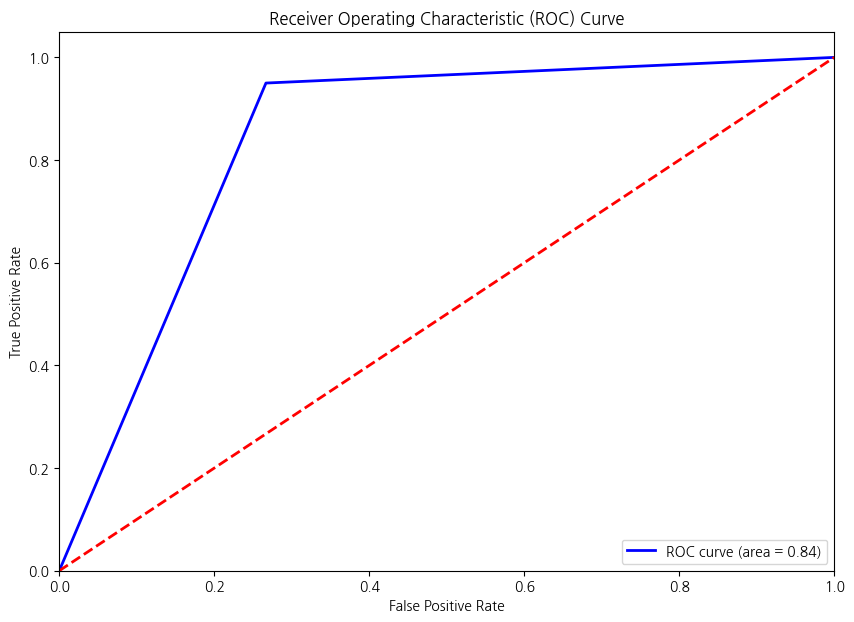

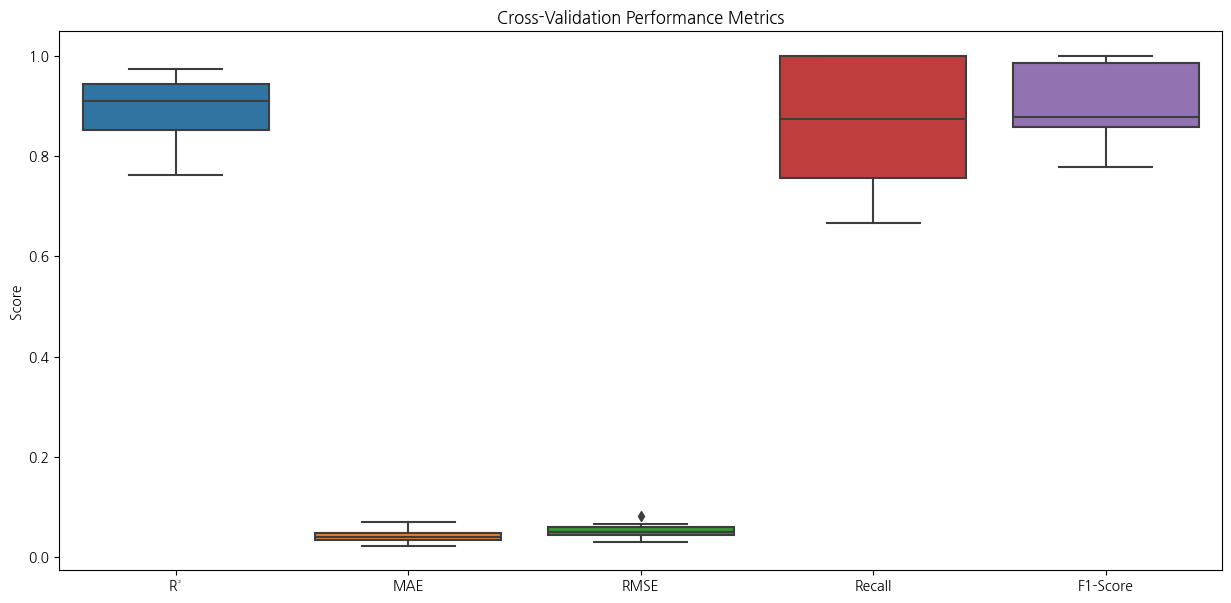

<Figure size 20000x10000 with 0 Axes>

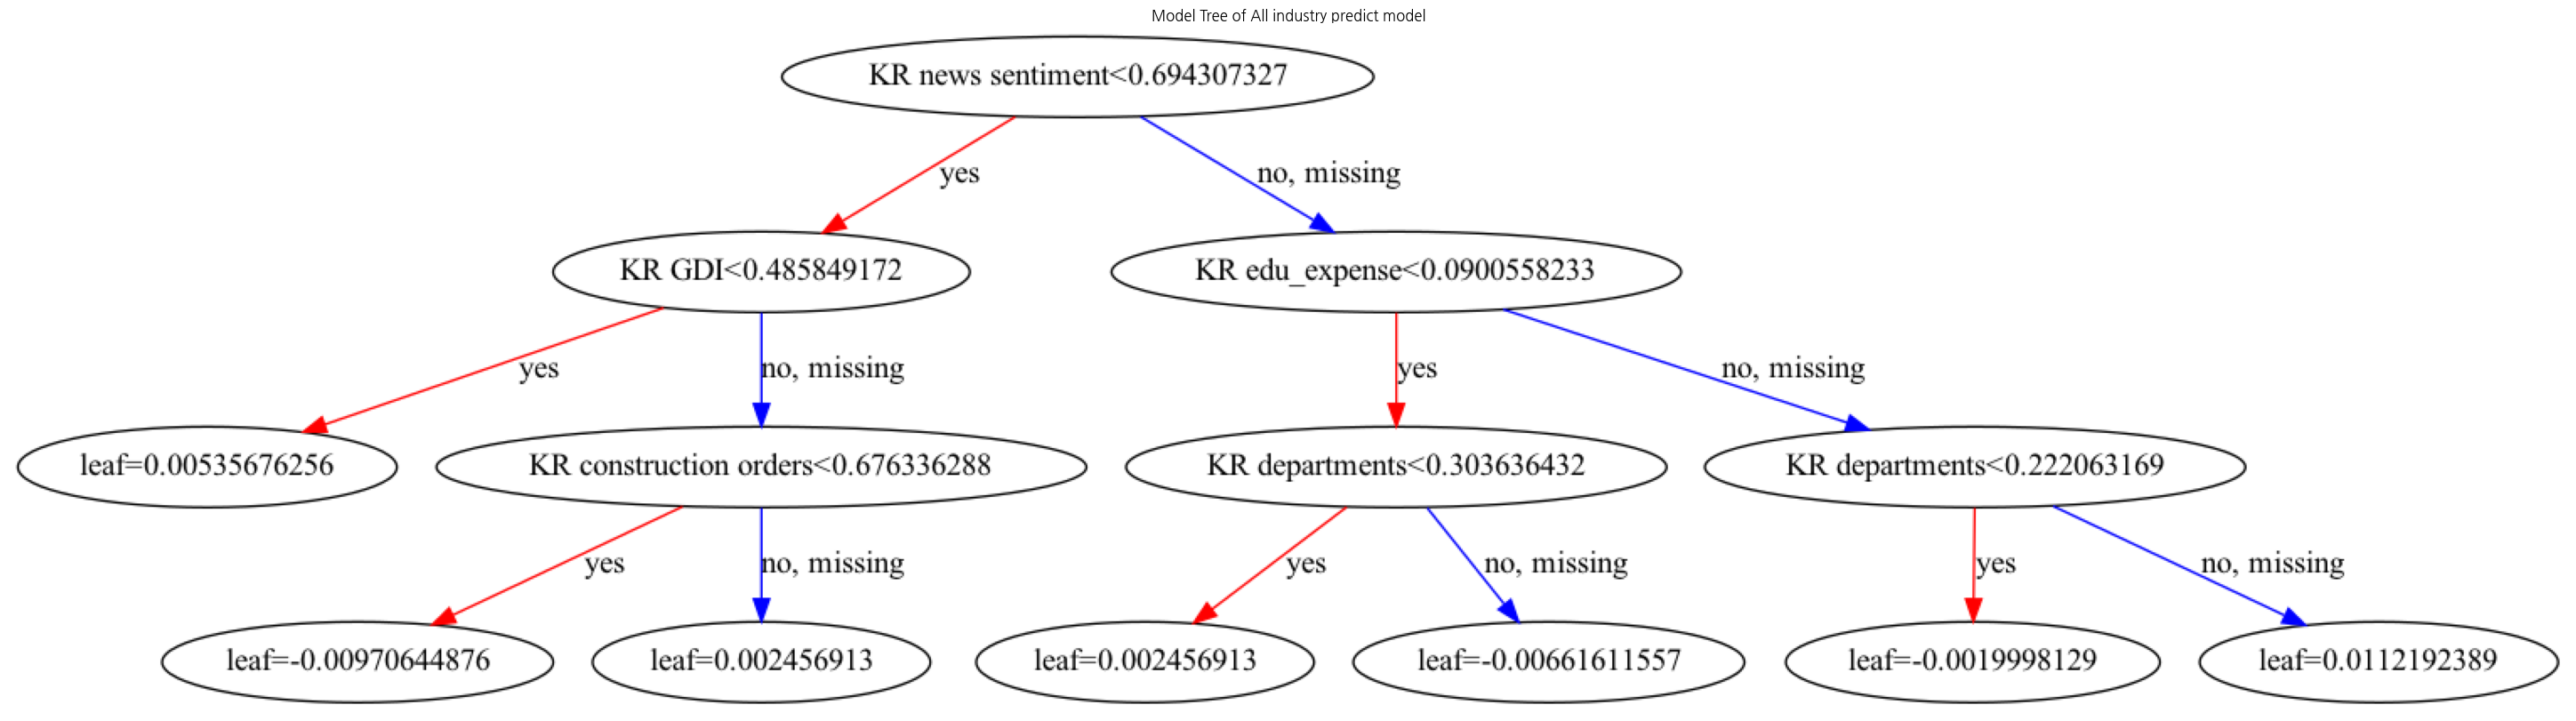

In [21]:
#############################
# XGBoost 학습곡선 확인 시각화
#############################
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import joblib 

best_model = joblib.load('model/xgboost_model.pkl')

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# 학습 곡선 플롯
plt.figure(figsize=(10, 5))
plot_learning_curve(best_model, "Learning Curve for XGBoost", X, Y, cv=5)
plt.savefig("picture/7-1-Learning Curve for XGBoost.png")
plt.show()

##############
# 매크로 경제 지표별 중요도 시각화
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt

# 특징 중요도 플롯
plt.figure(figsize=(10, 5))
plot_importance(best_model)
plt.savefig("picture/7-2-Feature importance for XGBoost.png")
plt.show()

###############
# 잔차(오차)분석 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 예측 값과 실제 값의 차이 계산
y_pred = best_model.predict(X_test)
residuals = Y_test - y_pred

# 잔차 플롯
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')

plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.savefig("picture/7-3-Residuals.png")
plt.show()


# 성능 지표 막대 그래프(모델의 R2, MAE, RMSE)
metrics = ['R²', 'MAE', 'RMSE']
values = [xgboost_r2, xgboost_mae, xgboost_rmse]

plt.figure(figsize=(10, 5))
plt.bar(metrics, values, color=['blue', 'green', 'red'])
plt.title('XGBoost Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.savefig("picture/7-4-Performance Metrics.png")
plt.show()


# 이진 분류로 변환을 위한 임계값 설정 (예: 중간값 기준)
threshold = np.median(Y_train)
Y_test_binary = (Y_test > threshold).astype(int)
xgboost_predictions_binary = (xgboost_predictions > threshold).astype(int)

# 혼동 행렬 시각화
conf_matrix = confusion_matrix(Y_test_binary, xgboost_predictions_binary)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("picture/7-5-Confusion Matrix.png")
plt.show()


# ROC 곡선 시각화(모델의 Recall, F1-Score)
fpr, tpr, _ = roc_curve(Y_test_binary, xgboost_predictions_binary)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("picture/7-6-ROC Curve.png")
plt.show()


# 교차 검증 평가지표 박스 플롯
cv_metrics = {
    'R²': cross_val_r2_scores,
    'MAE': -cross_val_mae_scores,  # neg_mean_absolute_error이므로 음수 처리
    'RMSE': -cross_val_rmse_scores,  # neg_root_mean_squared_error이므로 음수 처리
    'Recall': cross_val_recall_scores,
    'F1-Score': cross_val_f1_scores
}
cv_results = pd.DataFrame(cv_metrics)
plt.figure(figsize=(15, 7))
sns.boxplot(data=cv_results)
plt.title('Cross-Validation Performance Metrics')
plt.ylabel('Score')
plt.savefig("picture/7-7-Cross-Validation Performance Metrics.png")
plt.show()


# 트리 구조 시각화
plt.figure(figsize=(200, 100))  # 사이즈 조정
xgb.plot_tree(best_model, num_trees=0)
plt.title('Model Tree of All industry predict model')
plt.savefig("picture/7-8-Model Tree.png")
plt.show()


In [23]:
# 중요한 특징 확인
importance = best_model.get_booster().get_score(importance_type='weight')
importance_sorted = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# 출력
for feature, score in importance_sorted:
    print(f"Feature: {feature}, Score: {score}")

Feature: KR CCSI, Score: 475.0
Feature: KR EU currency, Score: 452.0
Feature: KR construction orders, Score: 352.0
Feature: KR JP currency, Score: 348.0
Feature: KR news sentiment, Score: 329.0
Feature: us_inflation_expectations, Score: 322.0
Feature: KR GDI, Score: 309.0
Feature: KR CN currency, Score: 307.0
Feature: KR coal energy consumption, Score: 280.0
Feature: KR departments, Score: 264.0
Feature: KR entry, Score: 253.0
Feature: world_oil_prices, Score: 233.0
Feature: KR total energy consumption, Score: 228.0
Feature: KR US currency, Score: 210.0
Feature: KR employment rate, Score: 163.0
Feature: KR GDP, Score: 142.0
Feature: us_unemployment_rate, Score: 133.0
Feature: us_interest_rate, Score: 108.0
Feature: KR GNI, Score: 105.0
Feature: KR house prices, Score: 93.0
Feature: KR edu_expense, Score: 86.0
Feature: KR consumers prices, Score: 83.0
Feature: KR unemployment rate, Score: 77.0
Feature: KR finedust, Score: 71.0
Feature: us_consumer_prices, Score: 70.0
Feature: KR interes

In [4]:
###########################
# 각 업종별로의 업황실적 예측모델링(매크로경제 데이터에 기반한) 구축 및 저장
###########################

from skopt import BayesSearchCV
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, recall_score, f1_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.preprocessing import MinMaxScaler
import matplotlib.font_manager as fm

# NanumGothic 글꼴 경로
font_path = 'font/NanumGothic.ttf'

# 글꼴 등록
fm.fontManager.addfont(font_path)
fontprop = fm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = fontprop.get_name()

# 데이터 불러오기
macro_file = 'Data/Summary/MacroEconomic.xlsx'
bsi_file = 'Data/Summary/Normalized_BSI_Data.xlsx'

macro_data = pd.read_excel(macro_file)
bsi_data = pd.read_excel(bsi_file)

macro_data['index'] = pd.to_datetime(macro_data['index'], format='%Y/%m')
bsi_data['업종_BSI'] = bsi_data['업종코드별'] + '_' + bsi_data['BSI코드별']
bsi_data = bsi_data.drop(columns=['업종코드별', 'BSI코드별']).set_index('업종_BSI').transpose()
bsi_data.index = pd.to_datetime(bsi_data.index, format='%Y/%m')

# 데이터 결합
merged_data = macro_data.merge(bsi_data, left_on='index', right_index=True, how='inner')
# 'index' 열이 datetime 형식이라면 문자열로 변환합니다.
merged_data['index_str'] = merged_data['index'].astype(str)
# '2024'가 포함된 행을 제외합니다.
merged_data_filtered = merged_data[~merged_data['index_str'].str.contains('2024')]
# 불필요한 'index_str' 열을 제거합니다.
merged_data = merged_data_filtered.drop(columns=['index_str'])

macro_columns = macro_data.columns[1:]
bsi_columns = [col for col in merged_data.columns if '업황실적' in col]

X = merged_data[macro_columns]
Y = merged_data[bsi_columns]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 데이터 스케일링
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled, X_test_scaled, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# GridSearchCV 방식 하이퍼파라미터 튜닝(미사용)
#param_grid = {
#    'n_estimators': [50, 100, 150],
#    'learning_rate': [0.01, 0.05, 0.1],
#    'max_depth': [2, 3, 4],
#    'subsample': [0.6, 0.7, 0.8],
#    'colsample_bytree': [0.6, 0.7, 0.8],
#    'reg_alpha': [0.0, 0.1, 0.5],  # L1 정규화
#    'reg_lambda': [1.0, 1.5, 2.0]  # L2 정규화
#}

# 베이시안 방식 하이퍼파라미터
param_space = {
    'n_estimators': (50, 500),
    'learning_rate': (0.01, 0.1),
    'max_depth': (3, 10),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0),
    'reg_alpha': (0.0, 1.0),  # L1 정규화
    'reg_lambda': (1.0, 2.0)  # L2 정규화
}
    
def train_and_evaluate(col):
    model = xgb.XGBRegressor(random_state=42)
    # GridSearch 모델링
    #grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=KFold(n_splits=5), scoring='r2', verbose=1)
    #grid_search.fit(X_train, Y_train[col])
    #best_model = grid_search.best_estimator_

    # 베이시안 모델링
    opt = BayesSearchCV(
        estimator=model,
        search_spaces=param_space,
        cv=3,
        n_iter=50,
        scoring='r2',
        random_state=42,
        verbose=1
    )
    opt.fit(X_train, Y_train[col])
    best_model = opt.best_estimator_    

    # 모델 저장
    joblib.dump(best_model, f'model/xgboost_model_{col}.pkl')

    # 모델 성능 평가
    predictions = best_model.predict(X_test)
    r2 = r2_score(Y_test[col], predictions)
    mae = mean_absolute_error(Y_test[col], predictions)
    rmse = np.sqrt(mean_squared_error(Y_test[col], predictions))

    print(f"{col} - XGBoost Model Performance")
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print()
    
    # 이진 분류 성능 평가
    threshold = np.median(Y_train[col])
    Y_test_binary = (Y_test[col] > threshold).astype(int)
    predictions_binary = (predictions > threshold).astype(int)
    
    recall = recall_score(Y_test_binary, predictions_binary)
    f1 = f1_score(Y_test_binary, predictions_binary)
    
    print("Binary Classification Performance")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print()

    # 교차 검증 수행(과적합 방지)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cross_val_r2_scores = cross_val_score(best_model, X, Y[col], cv=kfold, scoring='r2')
    cross_val_mae_scores = cross_val_score(best_model, X, Y[col], cv=kfold, scoring='neg_mean_absolute_error')
    
    print("Cross-Validation Performance")
    print(f"Mean Cross-Validation R²: {cross_val_r2_scores.mean():.4f}")
    print(f"Mean Cross-Validation MAE: {-cross_val_mae_scores.mean():.4f}")
    print()
    
    # 피처 중요도 시각화
    plt.figure(figsize=(10, 6))
    xgb.plot_importance(best_model, max_num_features=10, importance_type='weight')
    plt.title(f'Feature Importance for {col}')
    plt.show()
    plt.savefig(f"picture/7-Feature Importance for {col}.png")

    return best_model, r2, mae, rmse, recall, f1, cross_val_r2_scores.mean(), -cross_val_mae_scores.mean()

# 병렬 처리로 모델 학습 및 평가
results = Parallel(n_jobs=-1)(delayed(train_and_evaluate)(col) for col in bsi_columns)

# 결과 저장
results_df = pd.DataFrame(results, columns=['Model', 'R2', 'MAE', 'RMSE', 'Recall', 'F1-Score', 'Cross_R2', 'Cross_MAE'], index=bsi_columns)
results_df.to_csv('model/model_performance_result.csv')

<Figure size 2000x1500 with 0 Axes>

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


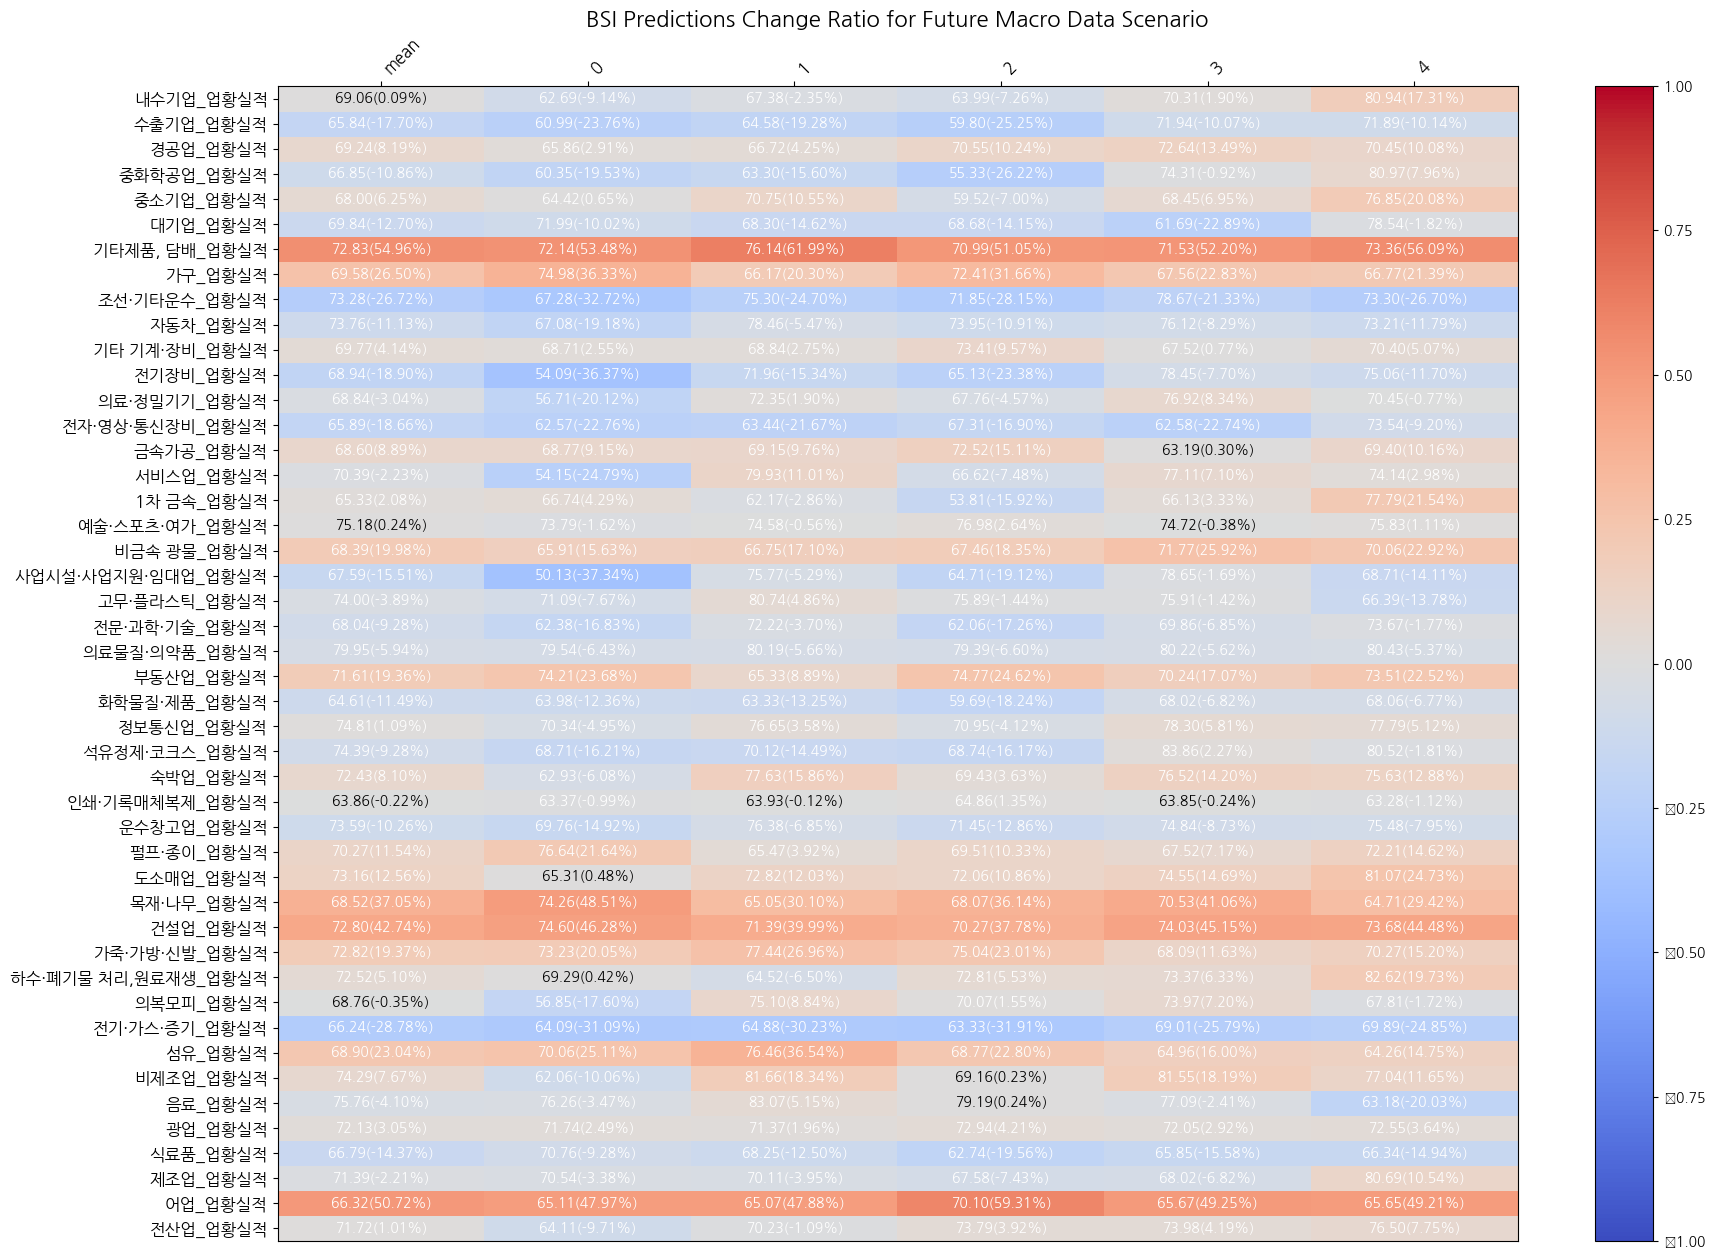

In [57]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.font_manager as fm

# NanumGothic 글꼴 경로
font_path = 'font/NanumGothic.ttf'

# 글꼴 등록
fm.fontManager.addfont(font_path)
fontprop = fm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = fontprop.get_name()

# 데이터 불러오기
macro_file = 'Data/Summary/MacroEconomic.xlsx'
bsi_file = 'Data/Summary/Normalized_BSI_Data.xlsx'
current_bsi_file = 'Data/산업/KR_bsi.xlsx'

macro_data = pd.read_excel(macro_file)
bsi_data = pd.read_excel(bsi_file)
current_bsi_values = pd.read_excel(current_bsi_file)

# BSI 데이터 전처리
macro_data['index'] = pd.to_datetime(macro_data['index'], format='%Y/%m')
bsi_data['업종_BSI'] = bsi_data['업종코드별'] + '_' + bsi_data['BSI코드별']
bsi_data = bsi_data.drop(columns=['업종코드별', 'BSI코드별']).set_index('업종_BSI').transpose()
bsi_data.index = pd.to_datetime(bsi_data.index, format='%Y/%m')

current_bsi_values['업종_BSI'] = current_bsi_values['업종코드별'] + '_' + current_bsi_values['BSI코드별']
current_bsi_values = current_bsi_values.drop(columns=['업종코드별', 'BSI코드별']).set_index('업종_BSI').transpose()
current_bsi_values.index = pd.to_datetime(current_bsi_values.index, format='%Y/%m')
bsi_columns = [col for col in current_bsi_values.columns if '업황실적' in col]

# 최신 데이터 불러오기
bsi_latest_values = bsi_data[bsi_columns].iloc[-1].astype(float) # Normalized BSI 중 가장 최신의 데이터 선택
current_bsi_latest_values = current_bsi_values[bsi_columns].iloc[-1].astype(float) # 실제값 중 가장 최신의 데이터 선택

merged_data = macro_data.merge(bsi_data, left_on='index', right_index=True, how='inner')

macro_columns = macro_data.columns[1:]
bsi_columns = [col for col in merged_data.columns if '업황실적' in col]

X = merged_data[macro_columns]
Y = merged_data[bsi_columns]

# 미래의 임의의 테스트용 매크로 데이터
future_macro_data = pd.DataFrame({
    'KR CCSI': [100, 102, 104, 106, 100],
    'KR CN currency': [0.15, 0.16, 0.14, 0.15, 0.14],
    'KR EU currency': [0.85, 0.84, 0.83, 0.82, 0.81],
    'KR GDI': [1200, 1250, 1230, 1280, 1000],
    'KR GDP': [1100, 1120, 1130, 1140, 1050],
    'KR GNI': [1150, 1170, 1160, 1180, 1090],
    'KR JP currency': [0.20, 0.21, 0.19, 0.20, 0.19],
    'KR US currency': [1.00, 1.01, 1.02, 1.03, 1.04],
    'KR coal energy consumption': [500, 510, 505, 515, 520],
    'KR construction orders': [300, 320, 310, 330, 340],
    'KR consumers prices': [105, 106, 107, 108, 109],
    'KR corruption perception index': [45, 46, 44, 45, 46],
    'KR crime count': [10000, 10200, 10100, 10300, 10400],
    'KR departments': [150, 155, 152, 157, 160],
    'KR edu_expense': [400, 410, 405, 420, 430],
    'KR employment rate': [70, 72, 71, 73, 74],
    'KR entry': [50, 52, 51, 53, 54],
    'KR finedust': [80, 82, 81, 83, 85],
    'KR gini': [0.35, 0.36, 0.34, 0.35, 0.36],
    'KR graduate': [200, 205, 203, 208, 210],
    'KR house prices': [900, 910, 905, 920, 930],
    'KR households': [5000, 5050, 5025, 5100, 5150],
    'KR interest': [2.5, 2.6, 2.55, 2.65, 2.7],
    'KR news sentiment': [60, 62, 61, 63, 64],
    'KR pop_elderly_rate': [15, 15.2, 15.1, 15.3, 15.4],
    'KR pop_natural_increase_rate': [1, 1.1, 1.05, 1.2, 1.3],
    'KR total energy consumption': [1000, 1010, 1005, 1020, 1030],
    'KR unemployment rate': [5, 5.1, 5.05, 5.2, 5.3],
    'us_consumer_prices': [110, 112, 111, 113, 114],
    'us_gdp': [18000, 18200, 18100, 18300, 18500],
    'us_inflation_expectations': [2.0, 2.1, 2.05, 2.2, 2.3],
    'us_interest_rate': [1.5, 1.6, 1.55, 1.65, 1.7],
    'us_nonfarm_employment': [150000, 151000, 150500, 152000, 153000],
    'us_unemployment_rate': [4.0, 4.1, 4.05, 4.2, 4.3],
    'world_oil_prices': [70, 71, 70.5, 72, 73]
})

# 데이터 스케일링
scaler = MinMaxScaler()
scaler.fit(future_macro_data)

# 스케일링된 데이터
future_macro_data_scaled = scaler.transform(future_macro_data)

# 시나리오 예측을 위한 함수 정의
def predict_scenario(scenario_data_scaled):
    predictions = {}
    for col in bsi_columns:
        model_path = f'model/xgboost_model_{col}.pkl'
        model = joblib.load(model_path)
        predictions[col] = model.predict(scenario_data_scaled)
    
    predictions_df = pd.DataFrame(predictions)
    return predictions_df

# 예측 수행
predictions_df_scaled = predict_scenario(future_macro_data_scaled)

# 예측 값을 원래 스케일로 변환
predictions_df = predictions_df_scaled * (current_bsi_latest_values.max() - current_bsi_latest_values.min()) + current_bsi_latest_values.min()

# 변화율 계산
def calculate_diff_ratio(predictions_df, current_values):
    diff_ratio = (predictions_df - current_values) / current_values
    return diff_ratio

# 변화율 계산
diff_ratio = calculate_diff_ratio(predictions_df, current_bsi_latest_values)

# 결과 시각화 함수(실제값, 변화율)
def plot_diff_ratio(diff_ratio_df, predictions_df, scenario_name):
    # 각 변동 간 평균 계산 
    diff_mean = diff_ratio_df.mean(axis=0)
    diff_mean.name = 'mean'
    diff_ratio_df = pd.concat([diff_mean.to_frame().T, diff_ratio_df])
    
    # 각 실예측값 간 평균 계산
    pred_mean = predictions_df.mean(axis=0)
    pred_mean.name = 'mean'
    predictions_df = pd.concat([pred_mean.to_frame().T, predictions_df])
    
    # heatmap 최대/최소값(vmax, vmin)을 지정(변화율 100% ~ -100%)
    vmin = -1
    vmax = 1
    
    plt.figure(figsize=(20, 15))
    fig, ax = plt.subplots(figsize=(20, 15))
    c = ax.pcolor(diff_ratio_df.T, cmap='coolwarm', vmin=vmin, vmax=vmax)
    fig.colorbar(c, ax=ax)

    # X축 레이블을 위로 이동
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    # 축 레이블 설정
    ax.set_xticks(np.arange(diff_ratio_df.shape[0]) + 0.5, minor=False)
    ax.set_yticks(np.arange(diff_ratio_df.shape[1]) + 0.5, minor=False)
    ax.set_xticklabels(diff_ratio_df.index, minor=False, rotation=45, ha='left', fontsize=12)
    ax.set_yticklabels(diff_ratio_df.columns, minor=False, fontsize=12)

    # 각 셀마다 숫자 표시
    for i in range(predictions_df.shape[0]):
        for j in range(predictions_df.shape[1]):
            value = predictions_df.iloc[i, j]
            rate = diff_ratio_df.iloc[i, j]
            if not np.isnan(value) and not np.isnan(rate):
                color = 'black' if abs(rate) < 0.005 else 'white'
                ax.text(i + 0.5, j + 0.5, f'{value:.2f}({rate:.2%})', 
                        horizontalalignment='center', verticalalignment='center', fontsize=10, color=color)
    
    plt.title(f'BSI Predictions Change Ratio for {scenario_name} Scenario', fontsize=16)
    plt.show()

# Plot predictions
plot_diff_ratio(diff_ratio, predictions_df, "Future Macro Data")


In [ ]:
############################################################
####### 아래부터는 연습용입니다. 무시하셔도 좋습니다. #############
############################################################

In [171]:
# 임시작업
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import statsmodels.api as sm


# NanumGothic 글꼴 경로
font_path = 'font/NanumGothic.ttf'

# 글꼴 등록
fm.fontManager.addfont(font_path)
fontprop = fm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = fontprop.get_name()

# 데이터 불러오기
macro_file = 'Data/Summary/MacroEconomic.xlsx'
bsi_file = 'Data/Summary/Normalized_BSI_Data.xlsx'

macro_data = pd.read_excel(macro_file)
bsi_data = pd.read_excel(bsi_file)

# 데이터 전처리
macro_data['index'] = pd.to_datetime(macro_data['index'], format='%Y/%m')
bsi_data['업종_BSI'] = bsi_data['업종코드별'] + '_' + bsi_data['BSI코드별']
bsi_data = bsi_data.drop(columns=['업종코드별', 'BSI코드별']).set_index('업종_BSI').transpose()
bsi_data.index = pd.to_datetime(bsi_data.index, format='%Y/%m')

# 데이터 결합
merged_data = macro_data.merge(bsi_data, left_on='index', right_index=True, how='inner')

In [188]:
# 'index' 열이 datetime 형식이라면 문자열로 변환합니다.
merged_data['index_str'] = merged_data['index'].astype(str)
# '2024'가 포함된 행을 제외합니다.
merged_data_filtered = merged_data[~merged_data['index_str'].str.contains('2024')]
# 불필요한 'index_str' 열을 제거합니다.
merged_data = merged_data_filtered.drop(columns=['index_str'])

index   KR CCSI  KR CN currency  KR EU currency    KR GDI    KR GDP  \
115 2009-08-01  0.912963        0.270963        0.853717  0.386761  0.410034   
116 2009-09-01  0.903704        0.270963        0.862120  0.386761  0.410034   
117 2009-10-01  1.000000        0.270963        0.828893  0.393179  0.418801   
118 2009-11-01  0.911111        0.270963        0.822241  0.393179  0.418801   
119 2009-12-01  0.881481        0.270963        0.787330  0.393179  0.418801   
..         ...       ...             ...             ...       ...       ...   
283 2023-08-01  0.640741        0.535433        0.506314  0.943359  0.966898   
284 2023-09-01  0.575926        0.544794        0.488870  0.943359  0.966898   
285 2023-10-01  0.546296        0.615034        0.493857  0.953466  0.977713   
286 2023-11-01  0.529630        0.509722        0.481412  0.953466  0.977713   
287 2023-12-01  0.574074        0.549729        0.488519  0.953466  0.977713   

       KR GNI  KR JP currency  KR US currency  KR coal energy consumption  \
115  0.402799        0.694131        0.590598                    0.353392   
116  0.402799        0.729685        0.555366                    0.511351   
117  0.407867        0.689659        0.474968                    0.384573   
118  0.407867        0.694282        0.454799                    0.450766   
119  0.407867        0.689697        0.458867                    0.469365   
..        ...             ...             ...                         ...   
283  0.998623        0.197121        0.737228                    0.622538   
284  0.998623        0.184783        0.757372                    0.408780   
285  1.000000        0.187403        0.796230                    0.409601   
286  1.000000        0.150163        0.722429                    0.352845   
287  1.000000        0.188802        0.710690                    0.530361   

     ...  자동차_채산성실적  조선·기타운수_채산성실적  가구_채산성실적  기타제품, 담배_채산성실적  대기업_채산성실적  \
115  ...   0.243902       0.777778  0.770492        0.904762   0.606061   
116  ...   0.609756       0.511111  1.000000        0.928571   0.787879   
117  ...   0.414634       0.488889  0.852459        0.880952   0.606061   
118  ...   0.512195       0.488889  0.754098        1.000000   0.484848   
119  ...   0.536585       0.555556  0.622951        1.000000   0.575758   
..   ...        ...            ...       ...             ...        ...   
283  ...   0.634146       0.711111  0.327869        0.452381   0.242424   
284  ...   0.560976       0.577778  0.295082        0.500000   0.303030   
285  ...   0.487805       0.488889  0.295082        0.214286   0.424242   
286  ...   0.487805       1.000000  0.327869        0.119048   0.454545   
287  ...   0.463415       0.622222  0.262295        0.500000   0.363636   

     중소기업_채산성실적  중화학공업_채산성실적  경공업_채산성실적  수출기업_채산성실적  내수기업_채산성실적  
115        0.96     0.791667   0.800000    0.696970    0.818182  
116        0.88     0.791667   0.900000    0.727273    0.818182  
117        0.96     0.750000   0.966667    0.666667    0.818182  
118        1.00     0.750000   0.766667    0.545455    0.863636  
119        0.96     0.750000   0.966667    0.666667    0.818182  
..          ...          ...        ...         ...         ...  
283        0.44     0.333333   0.333333    0.272727    0.318182  
284        0.28     0.250000   0.300000    0.181818    0.318182  
285        0.16     0.291667   0.300000    0.484848    0.090909  
286        0.28     0.458333   0.200000    0.606061    0.181818  
287        0.36     0.333333   0.366667    0.393939    0.272727  

[173 rows x 566 columns]

In [196]:
from PIL import Image

logo_path = "flask/static/images/logo.png"
logo_image = Image.open(logo_path)

logo_image = logo_image.convert("RGBA")
transparent_logo_path = "flask/static/images/logo_transparent.png"
logo_image.save(transparent_logo_path)

In [ ]:
#테스트 세트 성능:
# R²: 0.8973: 모델이 테스트 데이터에서 89.73%의 분산을 설명합니다. 이는 매우 높은 설명력을 의미합니다.
# MAE: 0.0483: 평균 절대 오차가 0.0483입니다. 이는 모델의 예측 값과 실제 값 사이의 평균적인 차이를 나타내며, 작은 값일수록 예측이 정확함을 의미합니다.

#교차 검증 성능:
# Mean Cross-Validation R²: -4.4370: 매우 낮은 R² 값이며, 심지어 음수입니다. 이는 모델이 교차 검증 세트에서 매우 나쁜 성능을 보였다는 것을 의미합니다.
# Mean Cross-Validation MAE: 0.2018: 교차 검증에서의 평균 절대 오차는 0.2018로, 테스트 세트에서보다 훨씬 높습니다.#

########### 가능한 원인 및 조치 ###########
#과적합 (Overfitting)
# 모델이 학습 데이터에 과적합되어 새로운 데이터에 대한 일반화 성능이 매우 낮아질 수 있습니다.
# 이를 방지하기 위해 더 많은 데이터를 수집하거나, 모델의 복잡성을 줄이기 위한 규제를 강화할 수 있습니다.
# 하이퍼파라미터 튜닝을 다시 수행할 때, max_depth, n_estimators 등의 값을 줄이거나, subsample과 colsample_bytree를 조정해볼 수 있습니다.

#데이터 불균형 (Data Imbalance)
# 특정 범위의 데이터가 다른 범위의 데이터보다 많이 포함되어 있을 경우, 모델이 일부 데이터에만 잘 맞게 학습될 수 있습니다.
# 데이터 전처리 단계에서 데이터의 균형을 맞추기 위한 방법을 사용할 수 있습니다.

#데이터 누락 및 품질 (Data Quality)
# 데이터 세트에 결측치가 있거나, 데이터 품질이 좋지 않을 경우 모델 성능이 저하될 수 있습니다.
# 데이터 전처리를 통해 결측치를 처리하고, 데이터의 품질을 개선할 수 있습니다.

#교차 검증 방법론
# 교차 검증의 분할 방식이 데이터의 분포를 제대로 반영하지 못할 경우, 이런 결과가 나올 수 있습니다.
# 다른 교차 검증 방법 (예: K-Fold 대신 TimeSeriesSplit) 등을 시도해볼 수 있습니다.


###################################################
#데이터 분할 방법 변경:
# 데이터를 훈련 세트와 테스트 세트로 분할할 때, 샘플링 방식이나 비율을 조정해보세요.
# 시계열 데이터의 경우 시계열 분할을 고려할 수 있습니다.

#데이터 증강 및 더 많은 데이터 수집:
# 더 많은 데이터를 수집하거나, 데이터 증강 기법을 사용하여 훈련 데이터를 늘리는 것이 도움이 될 수 있습니다.

#모델의 복잡도 줄이기:
# 모델의 복잡도를 줄이기 위해 하이퍼파라미터를 조정합니다. 예를 들어, max_depth, min_child_weight, gamma, subsample, colsample_bytree 등의 값을 조정합니다.
# 너무 복잡한 모델이 오버피팅될 수 있으므로, 단순한 모델부터 시작해서 점진적으로 복잡도를 높여가는 것이 좋습니다.

#교차 검증 전략 변경:
# 교차 검증의 폴드 수를 늘리거나, 다른 교차 검증 기법을 사용해보세요.
# 예를 들어, K-Fold 대신에 Stratified K-Fold를 사용하면 더 균일한 분할이 가능합니다.

#정규화 기법 사용:
# 정규화 기법(L1, L2)을 사용하여 모델의 가중치를 제한합니다.


####################################################
# 좋은 결과를 얻으셨습니다! 교차 검증 성능이 크게 향상되었고, 테스트 세트의 성능과 일치하는 양상을 보입니다. 이는 모델이 과적합되지 않고, 일반화 성능이 우수하다는 것을 의미합니다. 이제 모델이 실제 데이터에서도 좋은 성능을 발휘할 가능성이 높습니다.

###결과 해석
# 테스트 세트 성능:
# R²: 0.9191
# MAE: 0.0393

#교차 검증 성능:
# Mean Cross-Validation R²: 0.8988
# Mean Cross-Validation MAE: 0.0445

# R² 값이 높고 MAE 값이 낮은 것을 볼 때, 모델이 실제 데이터에서도 우수한 성능을 보일 가능성이 높습니다.

# 좋은 결과를 얻으셨습니다! 교차 검증 성능이 크게 향상되었고, 테스트 세트의 성능과 일치하는 양상을 보입니다. 이는 모델이 과적합되지 않고, 일반화 성능이 우수하다는 것을 의미합니다. 이제 모델이 실제 데이터에서도 좋은 성능을 발휘할 가능성이 높습니다.

###결과 해석
# 테스트 세트 성능:
# R²: 0.9191
# MAE: 0.0393

#교차 검증 성능:
# Mean Cross-Validation R²: 0.8988
# Mean Cross-Validation MAE: 0.0445

# R² 값이 높고 MAE 값이 낮은 것을 볼 때, 모델이 실제 데이터에서도 우수한 성능을 보일 가능성이 높습니다.

Mean Squared Error: 1.8268911610652698


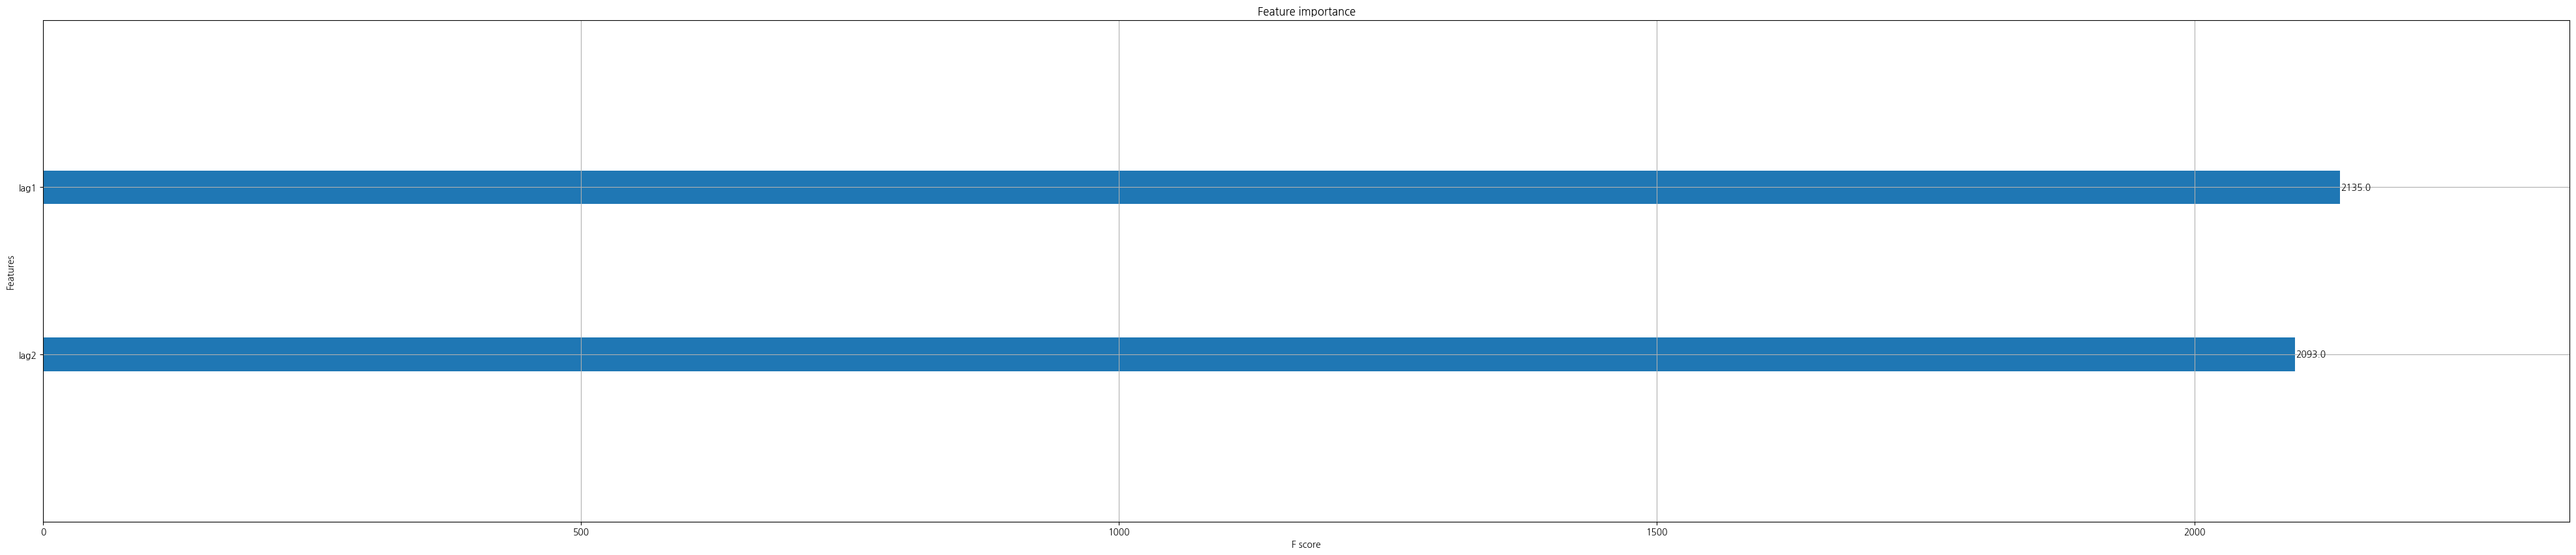

<Figure size 20000x10000 with 0 Axes>

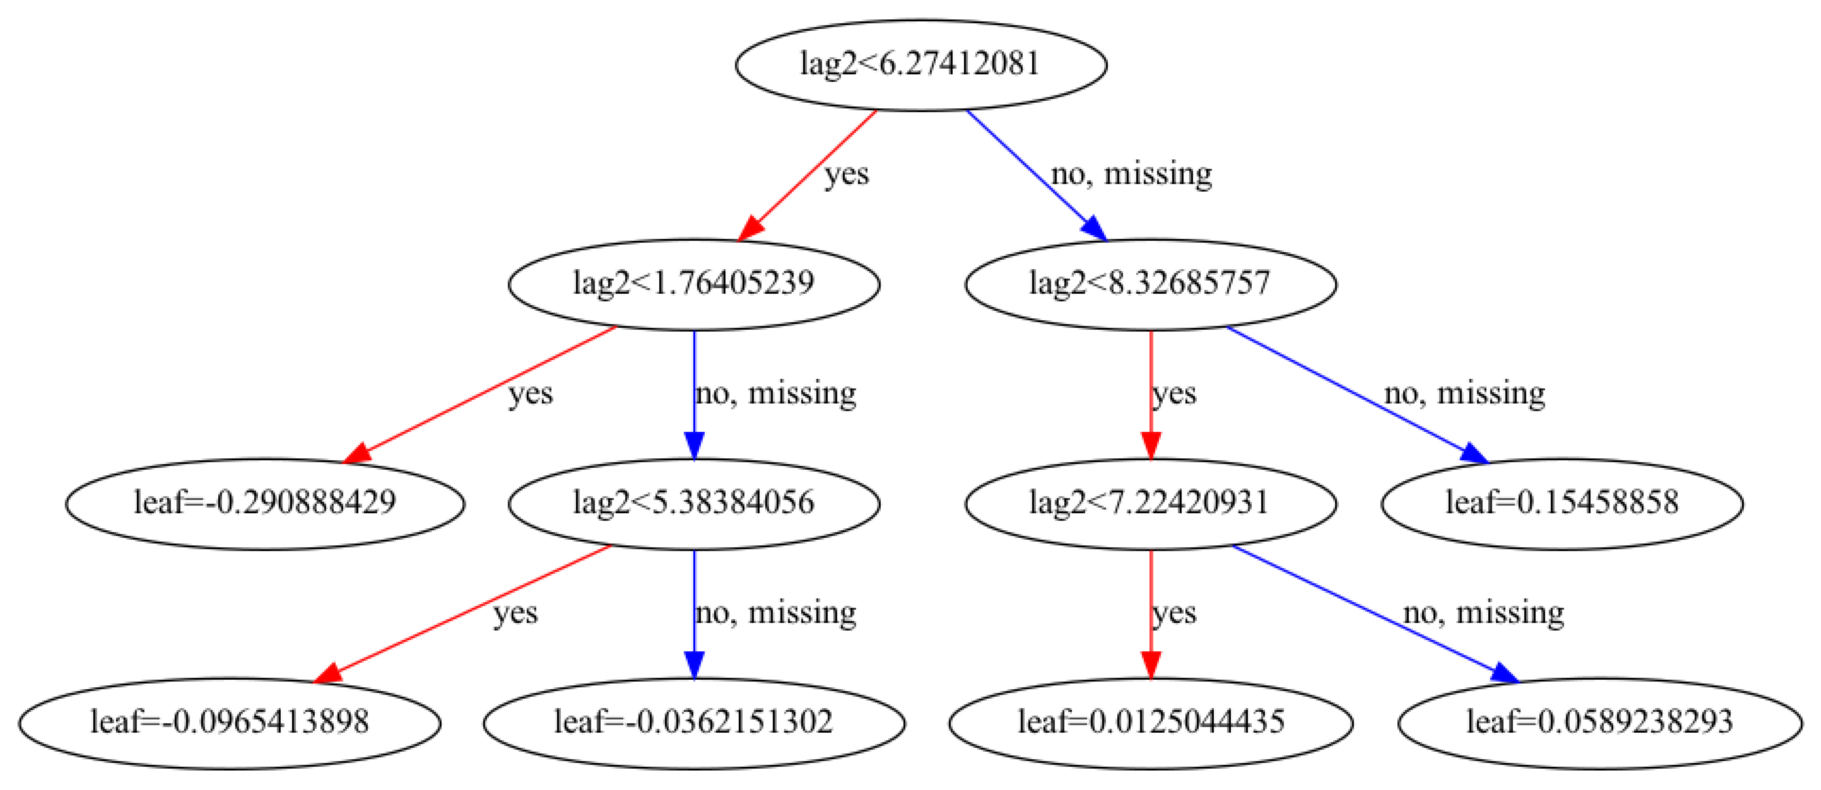

In [41]:
import xgboost as xgb
import joblib
import pandas as pd
import numpy as np
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 예제 데이터 생성
np.random.seed(0)
date_range = pd.date_range(start='1/1/2020', periods=100, freq='M')
data = pd.DataFrame({'value': np.random.randn(100).cumsum()}, index=date_range)

# Lag Features 생성
data['lag1'] = data['value'].shift(1)
data['lag2'] = data['value'].shift(2)
data = data.dropna()

# 학습 데이터 준비
X = data[['lag1', 'lag2']]
y = data['value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 베이시안 방식 하이퍼파라미터
param_space = {
    'n_estimators': (50, 1000),
    'learning_rate': (0.001, 0.1),
    'max_depth': (3, 15),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'reg_alpha': (0.0, 1.0),  # L1 정규화
    'reg_lambda': (1.0, 10.0)  # L2 정규화
}

# XGBoost 모델 학습 (베이시안 최적화 사용)
xgboost_model = xgb.XGBRegressor(random_state=42)
opt = BayesSearchCV(
    estimator=xgboost_model,
    search_spaces=param_space,
    cv=5,
    n_iter=100,
    scoring='r2',
    random_state=42,
    verbose=0
)
opt.fit(X_train, y_train)
best_model = opt.best_estimator_

# 모델 저장
#joblib.dump(best_model, 'xgboost_best_model.pkl')

# 예측 및 평가
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# 중요 피처 시각화
xgb.plot_importance(best_model)
plt.show()

# 트리 구조 시각화
plt.figure(figsize=(200, 100))
xgb.plot_tree(best_model, num_trees=0)
plt.show()


/var/folders/_x/85c_20bd0yg0yw7bsqgk4qbh0000gp/T/ipykernel_10271/3831857709.py:94: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig("picture/3-Correlation macro with bsi.png")


<Figure size 2000x1500 with 0 Axes>

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


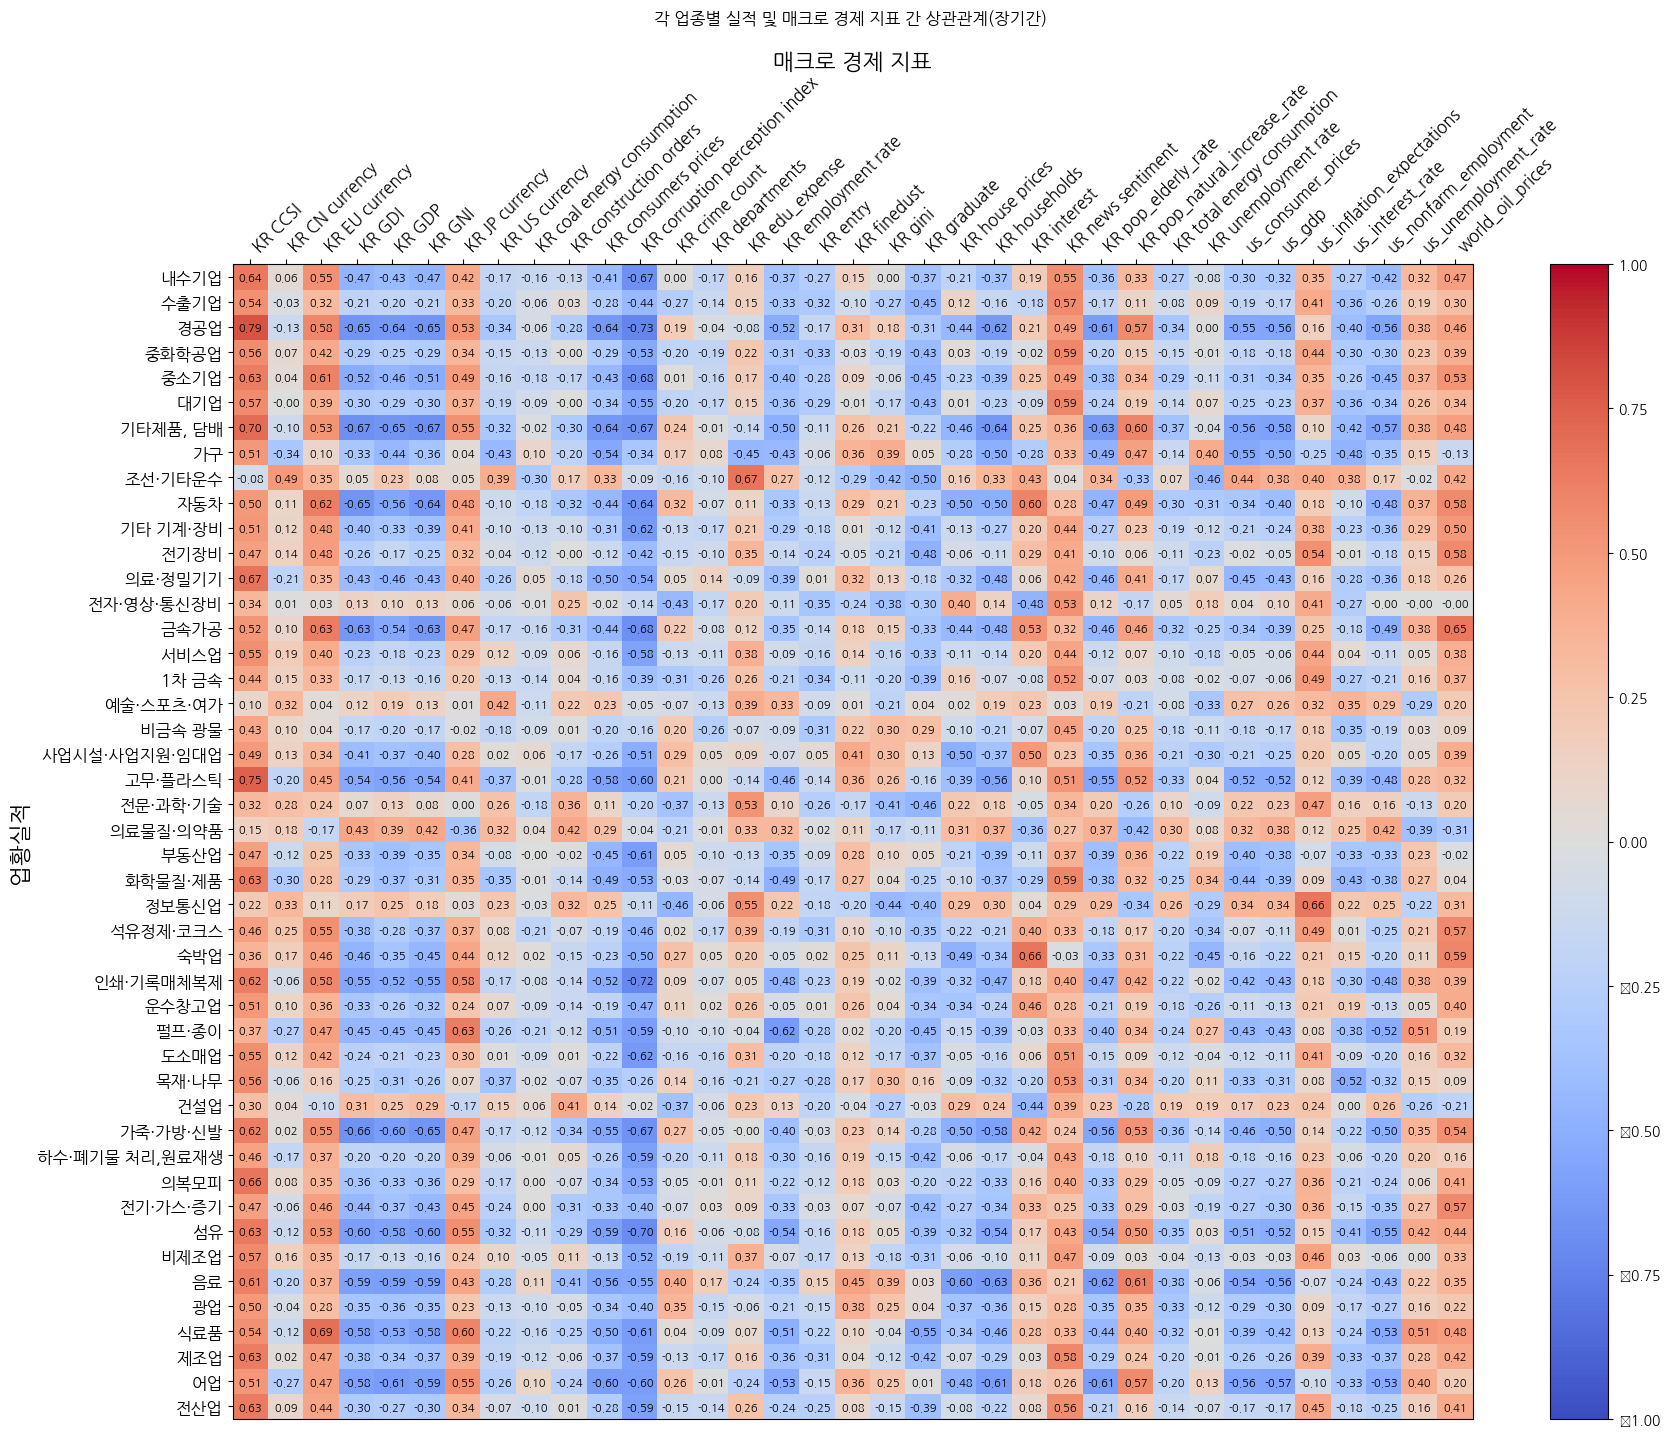

In [79]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import statsmodels.api as sm



# NanumGothic 글꼴 경로
font_path = 'font/NanumGothic.ttf'

# 글꼴 등록
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = fontprop.get_name()

# 데이터 불러오기
macro_file = 'Data/Summary/MacroEconomic.xlsx'
bsi_file = 'Data/Summary/Normalized_BSI_Data.xlsx'

macro_data = pd.read_excel(macro_file)
bsi_data = pd.read_excel(bsi_file)

# 데이터 전처리
macro_data['index'] = pd.to_datetime(macro_data['index'], format='%Y/%m')
bsi_data['업종_BSI'] = bsi_data['업종코드별'] + '_' + bsi_data['BSI코드별']
bsi_data = bsi_data.drop(columns=['업종코드별', 'BSI코드별']).set_index('업종_BSI').transpose()
bsi_data.index = pd.to_datetime(bsi_data.index, format='%Y/%m')

# 데이터 결합
merged_data = macro_data.merge(bsi_data, left_on='index', right_index=True, how='inner')
# 'index' 열이 datetime 형식이라면 문자열로 변환합니다.
merged_data['index_str'] = merged_data['index'].astype(str)
# '2024'가 포함된 행을 제외합니다.
merged_data_filtered = merged_data[~merged_data['index_str'].str.contains('2024')]
# 불필요한 'index_str' 열을 제거합니다.
merged_data = merged_data_filtered.drop(columns=['index_str'])

#merged_data['KR GDP'] = merged_data['KR GDP'].diff() 
#merged_data['KR GNI'] = merged_data['KR GNI'].diff() 
#merged_data['KR GDI'] = merged_data['KR GDI'].diff() 
#merged_data['KR CCSI'] = merged_data['KR CCSI'].diff() 

# 상관관계 분석
macro_columns = macro_data.columns[1:]  # 매크로 경제 지표
bsi_columns = [col for col in merged_data.columns if '업황실적' in col]  # 업황실적 데이터

# 숫자형 데이터만 사용하여 상관관계 분석
numeric_macro_data = merged_data[macro_columns].select_dtypes(include=[np.number])
numeric_bsi_data = merged_data[bsi_columns].select_dtypes(include=[np.number])

correlation_matrix = pd.concat([numeric_macro_data, numeric_bsi_data], axis=1).corr()
macro_bsi_correlation = correlation_matrix.loc[macro_columns, bsi_columns]

# 업종 순서 조정
# macro_bsi_correlation_industry_order = sorted([ind for ind in macro_bsi_correlation.index if ind != '전산업'], reverse=True) + ['전산업']
# normalized_coefficients_df = normalized_coefficients_df.loc[industry_order]

# pcolor를 이용한 히트맵 시각화
plt.figure(figsize=(20, 15))
fig, ax = plt.subplots(figsize=(20, 15))
c = ax.pcolor(macro_bsi_correlation.T, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(c, ax=ax)

# X축 레이블을 위로 이동
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# 축 레이블 설정
ax.set_xticks(np.arange(macro_bsi_correlation.T.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(macro_bsi_correlation.T.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(macro_bsi_correlation.T.columns, minor=False, rotation=45, ha='left', fontsize=12)
ax.set_yticklabels(macro_bsi_correlation.T.index.str.replace("_업황실적",""), minor=False, fontsize=12)

# 각 셀마다 숫자 표시
for i in range(macro_bsi_correlation.T.shape[0]):
    for j in range(macro_bsi_correlation.T.shape[1]):
        ax.text(j + 0.5, i + 0.5, f'{macro_bsi_correlation.T.iloc[i, j]:.2f}', 
                horizontalalignment='center', verticalalignment='center', fontsize=8, color='black')

plt.xlabel('매크로 경제 지표', fontsize=16, fontproperties=font_prop)
plt.ylabel('업황실적', fontsize=16, fontproperties=font_prop)
plt.title("각 업종별 실적 및 매크로 경제 지표 간 상관관계(장기간) ", pad=20)
plt.savefig("picture/3-Correlation macro with bsi.png")
plt.show()


In [63]:
merged_data['KR CCSI'].diff()

115         NaN
116   -0.009259
117    0.096296
118   -0.088889
119   -0.029630
         ...   
283   -0.001852
284   -0.064815
285   -0.029630
286   -0.016667
287    0.044444
Name: KR CCSI, Length: 173, dtype: float64

In [4]:
from flask import Flask, render_template, request, jsonify, send_file, url_for
import pandas as pd
import numpy as np

models = {}
columns = []
subscriptions = []

current_macro_data = pd.DataFrame({
    'KR CCSI': [98.4],
    'KR CN currency': [187.91],
    'KR EU currency': [1475.43],
    'KR GDI': [489992.3],
    'KR GDP': [509845.7],
    'KR GNI': [481438.1],
    'KR JP currency': [869.14],
    'KR US currency': [1364.5],
    'KR coal energy consumption': [6040],
    'KR construction orders': [11673491],
    'KR consumers prices': [91.432],
    'KR corruption perception index': [29.3],
    'KR crime count': [161152.917],
    'KR departments': [45694.5],
    'KR edu_expense': [200400],
    'KR employment rate': [60.1],
    'KR entry': [50579.5],
    'KR finedust': [341],
    'KR gini': [0.345],
    'KR graduate': [558039],
    'KR house prices': [70.48],
    'KR households': [20153476],
    'KR interest': [3.5],
    'KR news sentiment': [109.2],
    'KR pop_elderly_rate': [19.2],
    'KR pop_natural_increase_rate': [-2.6],
    'KR total energy consumption': [21573],
    'KR unemployment rate': [3.5],
    'us_consumer_prices': [313.207],
    'us_gdp': [28284.5],
    'us_inflation_expectations': [3.1],
    'us_interest_rate': [5.50],
    'us_nonfarm_employment': [175000],
    'us_unemployment_rate': [3.9],
    'world_oil_prices': [77.8]
})

feature_translations = {
    'KR CCSI': '소비자심리지수(CCSI)',
    'KR CN currency': '중국환율',
    'KR EU currency': '유럽환율',
    'KR GDI': '국내총소득(GDI)',
    'KR GDP': '국내총생산(GDP)',
    'KR GNI': '국민총소득(GNI)',
    'KR JP currency': '일본환율',
    'KR US currency': '미국환율',
    'KR coal energy consumption': '총 석탄소비량',
    'KR construction orders': '건설수주액',
    'KR consumers prices': '소비자물가지수(CPI)',
    'KR corruption perception index': '부패인식지수',
    'KR crime count': '범죄발생건수',
    'KR departments': '출국자 수',
    'KR edu_expense': '사교육 지출액',
    'KR employment rate': '고용률',
    'KR entry': '입국자 수',
    'KR finedust': '미세먼지 지수',
    'KR gini': '지니계수',
    'KR graduate': '고등교육 졸업자 수',
    'KR house prices': '주택매매가격지수',
    'KR households': '세대 수',
    'KR interest': '금리',
    'KR news sentiment': '뉴스심리지수(NSI)',
    'KR pop_elderly_rate': '고령화지수',
    'KR pop_natural_increase_rate': '자연인구증가율',
    'KR total energy consumption': '총 에너지 소비량',
    'KR unemployment rate': '실업률',
    'us_consumer_prices': '미국 소비자물가지수',
    'us_gdp': '미국 GDP',
    'us_inflation_expectations': '미국 기대인플레이션',
    'us_interest_rate': '미국 기준금리',
    'us_nonfarm_employment': '미국 비농업 고용자수',
    'us_unemployment_rate': '미국 실업률',
    'world_oil_prices': '국제유가지수(WTI)'
}



### 재난 시나리오 데이터 생성
def generate_scenario_data(initial_value, monthly_decline, volatility, periods=12):
    return [round(initial_value * (1 + monthly_decline + np.random.uniform(-volatility, volatility))**month, 2) for month in range(periods)]

# 시나리오 데이터 생성 파라미터
scenario_params = {
    'KR CCSI': (-0.05, 0.02),  # 5% monthly decline, 2% volatility
    'KR CN currency': (0.03, 0.01),  # 3% monthly increase, 1% volatility
    'KR EU currency': (0.03, 0.01),
    'KR GDI': (-0.04, 0.02),
    'KR GDP': (-0.04, 0.02),
    'KR GNI': (-0.04, 0.02),
    'KR JP currency': (0.03, 0.01),
    'KR US currency': (0.03, 0.01),
    'KR coal energy consumption': (-0.03, 0.02),
    'KR construction orders': (-0.05, 0.02),
    'KR consumers prices': (0.02, 0.01),
    'KR corruption perception index': (0.05, 0.01),  # Increase in corruption perception
    'KR crime count': (0.04, 0.02),  # Increase in crime
    'KR departments': (-0.03, 0.02),
    'KR edu_expense': (-0.02, 0.01),
    'KR employment rate': (-0.03, 0.01),
    'KR entry': (-0.03, 0.02),
    'KR finedust': (0.01, 0.005),
    'KR gini': (0.01, 0.005),
    'KR graduate': (-0.02, 0.01),
    'KR house prices': (-0.04, 0.02),
    'KR households': (-0.01, 0.005),
    'KR interest': (0.01, 0.005),
    'KR news sentiment': (-0.05, 0.02),
    'KR pop_elderly_rate': (0.005, 0.002),
    'KR pop_natural_increase_rate': (-0.005, 0.002),
    'KR total energy consumption': (-0.02, 0.01),
    'KR unemployment rate': (0.02, 0.01),
    'us_consumer_prices': (0.01, 0.005),
    'us_gdp': (-0.01, 0.005),
    'us_inflation_expectations': (0.005, 0.002),
    'us_interest_rate': (0.005, 0.002),
    'us_nonfarm_employment': (-0.01, 0.005),
    'us_unemployment_rate': (0.01, 0.005),
    'world_oil_prices': (0.02, 0.01)
}

# 시나리오 데이터프레임 생성
scenario_data = {}
for key in current_macro_data.columns:
    initial_value = current_macro_data[key].iloc[0]
    monthly_decline, volatility = scenario_params[key]
    scenario_data[key] = generate_scenario_data(initial_value, monthly_decline, volatility)
disaster_scenario_df = pd.DataFrame(scenario_data)


In [6]:
disaster_scenario_df

KR CCSI  KR CN currency  KR EU currency     KR GDI     KR GDP     KR GNI  \
0     98.40          187.91         1475.43  489992.30  509845.70  481438.10   
1     94.23          193.08         1521.25  468233.74  499578.52  470146.11   
2     90.25          198.56         1536.64  463488.31  486651.57  460805.47   
3     79.23          205.42         1657.44  435390.19  478195.86  424792.49   
4     78.02          203.67         1684.24  386612.02  434308.67  421809.86   
5     83.33          225.91         1646.72  395142.92  443070.35  432580.18   
6     78.82          226.59         1723.26  367624.93  405649.33  421933.06   
7     76.81          231.52         1889.65  332939.98  344481.86  400274.62   
8     60.30          231.33         1761.74  365990.05  346637.26  301747.99   
9     67.25          239.59         2020.63  298834.89  327056.88  342596.10   
10    68.31          233.36         1864.88  387769.08  274688.18  348502.94   
11    61.56          281.26         1962.07  288978.58  277616.28  324578.70   

    KR JP currency  KR US currency  KR coal energy consumption  \
0           869.14         1364.50                     6040.00   
1           891.46         1394.81                     5872.71   
2           931.92         1437.48                     5457.33   
3           954.52         1469.79                     5664.99   
4          1016.53         1482.28                     5788.66   
5          1011.18         1518.46                     4764.88   
6          1013.56         1624.16                     4603.18   
7          1138.64         1635.42                     4776.29   
8          1055.40         1617.08                     4911.49   
9          1207.48         1712.49                     4214.11   
10         1262.09         1764.72                     4518.64   
11         1287.55         1727.36                     4467.07   

    KR construction orders  ...  KR pop_natural_increase_rate  \
0              11673491.00  ...                         -2.60   
1              10868369.46  ...                         -2.59   
2              10547503.05  ...                         -2.57   
3              10613086.38  ...                         -2.56   
4              10011634.62  ...                         -2.56   
5               8163230.90  ...                         -2.52   
6               8046570.83  ...                         -2.50   
7               8367414.35  ...                         -2.50   
8               8206678.47  ...                         -2.51   
9               8801911.76  ...                         -2.52   
10              6784489.02  ...                         -2.43   
11              6704435.92  ...                         -2.44   

    KR total energy consumption  KR unemployment rate  us_consumer_prices  \
0                      21573.00                  3.50              313.21   
1                      21175.77                  3.55              316.47   
2                      20797.69                  3.67              322.51   
3                      20731.50                  3.81              324.53   
4                      19433.54                  3.89              329.29   
5                      18861.08                  3.89              329.27   
6                      18400.59                  3.91              335.49   
7                      18942.06                  3.98              331.63   
8                      17305.43                  4.06              343.73   
9                      18767.10                  4.01              341.90   
10                     19235.59                  4.38              331.47   
11                     15541.04                  4.48              336.60   

      us_gdp  us_inflation_expectations  us_interest_rate  \
0   28284.50                       3.10              5.50   
1   28085.10                       3.12              5.53   
2   27965.72                       3.13              5.56   
3   27713.81

결측치 확인:
us_gdp                       6333
us_interest_rate             6138
us_inflation_expectations    1093
us_nonfarm_employment        6138
us_unemployment_rate         6138
us_consumer_prices           6138
world_oil_prices              326
dtype: int64
결측치 처리 후 확인:
us_gdp                         0
us_interest_rate               0
us_inflation_expectations    794
us_nonfarm_employment          0
us_unemployment_rate           0
us_consumer_prices             0
world_oil_prices               2
dtype: int64


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

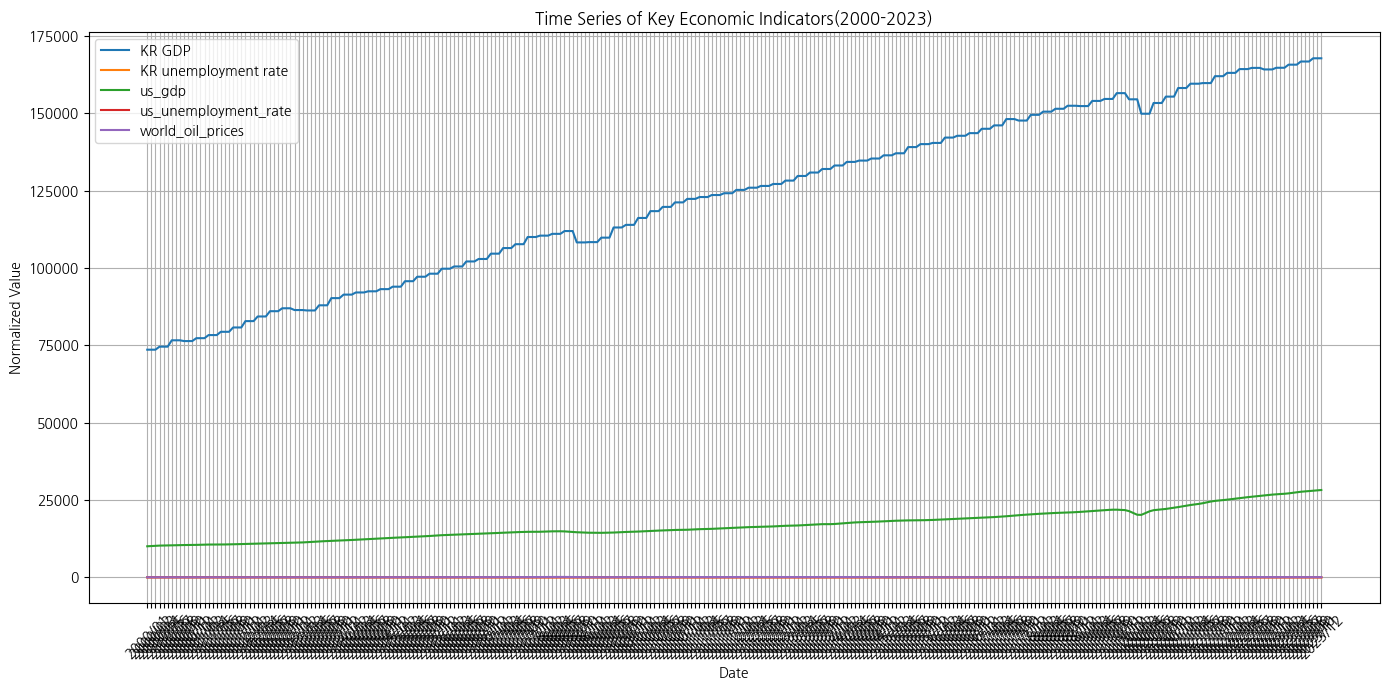

In [24]:
##### 월별 Real Data 결합
#############################
# fred 데이터 정규화 및 결측치 제거
#############################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from fredapi import Fred

# 한글 폰트 설정
font_path = 'font/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())

# 데이터 불러오기
fred = pd.read_excel("Data/Summary/fred.xlsx")
# 열 이름 변경
fred.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
# Date 열을 인덱스로 설정
fred.set_index('Date', inplace=True)
fred.index = pd.to_datetime(fred.index)

# 결측치 확인
print("결측치 확인:")
print(fred.isnull().sum())

# 결측치 처리 (예시: 선형 보간법 사용)
fred.interpolate(method='linear', inplace=True)

# 결측치가 있는지 확인
print("결측치 처리 후 확인:")
print(fred.isnull().sum())

# 월별 데이터로 변환 (각 월의 평균값 사용)
monthly_fred = fred.resample('M').mean()
monthly_fred = pd.DataFrame(monthly_fred, index=monthly_fred.index, columns=monthly_fred.columns)

# 데이터 저장
monthly_fred.to_excel('Data/Summary/monthly_fred_data_temp.xlsx')

fred_df = pd.read_excel('Data/Summary/monthly_fred_data_temp.xlsx')

# FRED 데이터의 'Date' 열을 결합된 데이터의 형식과 일치하도록 변환합니다
fred_df['Date'] = pd.to_datetime(fred_df['Date']).dt.strftime('%Y/%m')

# 결합된 데이터의 형식과 일치하도록 FRED 데이터의 위치를 바꿉니다
fred_transposed = fred_df.set_index('Date').T
fred_transposed



# 연간 데이터를 월별 형식으로 변환
yearly_data_melted = yearly_df.melt(id_vars=['Data'], var_name='Year', value_name='Value')

# 연간 데이터에서 월별 데이터로 데이터 프레임 생성
yearly_data_monthly_list = []
for index, row in yearly_data_melted.iterrows():
    for month in range(1, 13):
        monthly_row = {
            'Data': row['Data'],
            'Date': f"{row['Year']}/{month:02d}",
            'Value': row['Value']
        }
        yearly_data_monthly_list.append(monthly_row)
yearly_data_monthly = pd.DataFrame(yearly_data_monthly_list)

# 원래 월별 데이터의 형식과 일치하도록 데이터 프레임을 피벗
yearly_pivot = yearly_data_monthly.pivot(index='Data', columns='Date', values='Value')

# 월별 및 연간 데이터 프레임 결합
combined_df = monthly_df.set_index('Data').combine_first(yearly_pivot)

#각 행의 중앙값으로 결측값 채우기
combined_df = combined_df.apply(lambda row: row.fillna(row.median()), axis=1)



#두 데이터 세트를 결합
combined_normalized_df = combined_df.combine_first(fred_transposed).T

# 'Date'를 다시 열로 만들기 위해 인덱스 재설정
combined_normalized_df.reset_index(inplace=True)

# 그림을 그릴 몇 개의 핵심 열 선택
selected_columns = ['KR GDP', 'KR unemployment rate', 'us_gdp', 'us_unemployment_rate', 'world_oil_prices']

# 선택한 열 그림 그리기
def plot_time_series(data, columns, title):
    plt.figure(figsize=(14, 7))
    for column in columns:
        sns.lineplot(x=data['index'], y=data[column], label=column)
    plt.xlabel('Date')
    plt.ylabel('Normalized Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    #plt.savefig("picture/2-Time Series of Key Economic Indicators.png")
    plt.show()


# 'index' 열이 datetime 형식이라면 문자열로 변환합니다.
combined_normalized_df['index_str'] = combined_normalized_df['index'].astype(str)
# '2024'가 포함된 행을 제외합니다.
combined_normalized_df_filtered = combined_normalized_df[~combined_normalized_df['index_str'].str.contains('2024')]
# 불필요한 'index_str' 열을 제거합니다.
normalized_df_adjust = combined_normalized_df_filtered.drop(columns=['index_str'])
#plot_time_series(normalized_df, selected_columns, 'Time Series of Key Economic Indicators(2000-2023)')
plot_time_series(normalized_df_adjust, selected_columns, 'Time Series of Key Economic Indicators(2000-2023)')

combined_normalized_df.to_excel('Data/Summary/real_MacroEconomics.xlsx')

In [34]:
covid_data = pd.read_excel('Data/Summary/covid_data.xlsx')
covid_scenario_df = pd.DataFrame(covid_data)
round(covid_scenario_df, 2)

index  KR CCSI  KR CN currency  KR EU currency     KR GDI     KR GDP  \
0   2019/11    102.0          166.27         1290.56  151776.43  156535.60   
1   2019/12    101.5          167.58         1306.33  151776.43  156535.60   
2   2020/01    105.3          168.01         1293.70  151042.83  154537.80   
3   2020/02     98.0          170.48         1302.33  151042.83  154537.80   
4   2020/03     79.7          173.78         1350.35  151042.83  154537.80   
5   2020/04     72.1          172.92         1331.71  147898.30  149877.77   
6   2020/05     78.8          172.52         1338.74  147898.30  149877.77   
7   2020/06     83.1          170.65         1361.77  147898.30  149877.77   
8   2020/07     85.4          170.92         1372.98  151911.93  153347.37   
9   2020/08     89.3          171.14         1403.36  151911.93  153347.37   
10  2020/09     80.7          172.98         1391.02  151911.93  153347.37   
11  2020/10     92.7          170.51         1347.55  153784.10  155411.50   
12  2020/11     99.1          169.07         1320.66  153784.10  155411.50   
13  2020/12     91.0          167.63         1331.75  153784.10  155411.50   

       KR GNI  KR JP currency  KR US currency  KR coal energy consumption  \
0   153192.70         1072.87         1167.45                        7111   
1   153192.70         1077.22         1175.84                        7415   
2   152314.27         1065.25         1164.28                        6491   
3   152314.27         1084.95         1193.79                        6056   
4   152314.27         1134.74         1220.09                        5358   
5   148949.70         1135.31         1225.22                        6190   
6   148949.70         1145.65         1228.67                        5520   
7   148949.70         1124.68         1210.01                        6234   
8   153052.97         1122.38         1198.90                        7133   
9   153052.97         1119.52         1186.84                        6668   
10  153052.97         1116.00         1178.80                        7173   
11  155543.03         1088.09         1144.68                        5927   
12  155543.03         1069.40         1116.76                        5947   
13  155543.03         1054.81         1095.13                        7286   

    ...  KR pop_natural_increase_rate  KR total energy consumption  \
0   ...                           0.1                        24635   
1   ...                           0.1                        28591   
2   ...                          -0.6                        26210   
3   ...                          -0.6                        24731   
4   ...                          -0.6                        23301   
5   ...                          -0.6                        22757   
6   ...                          -0.6                        22300   
7   ...                          -0.6                        22393   
8   ...                          -0.6                        23288   
9   ...                          -0.6                        23015   
10  ...                          -0.6                        23214   
11  ...                          -0.6                        22577   
12  ...                          -0.6                        23639   
13  ...                          -0.6                        28085   

    KR unemployment rate  us_consumer_prices    us_gdp  \
0                    3.6              258.24  21805.91   
1                    3.5              258.76  21741.60   
2                    3.6              259.07  21412.08   
3                    3.4              258.72  20823.21   
4                    3.9              257.18  20234.34   
5                    3.9              255.99  20193.33   
6                    4.4              256.40  20767.05   
7                    4.2              257.67  21340.77   
8                    4.1              258.87  21709.51   
9                    3.7              259.65  21

In [47]:
import pandas as pd
import numpy as np

df = pd.read_excel('Data/Summary/real_MacroEconomics.xlsx')
df = df.drop('Unnamed: 0', axis=1)
#df = df[(df['index'] == "2019/11") | (df['index'] == "2019/12") | (df['index'] == "2020/01") | (df['index'] == "2020/02") | (df['index'] == "2020/03") | (df['index'] == "2020/04") | (df['index'] == "2020/05")]
df = df[df['index'].str.contains("2019") | (df['index'] == "2020/01") | (df['index'] == "2020/02") | (df['index'] == "2020/03") | (df['index'] == "2020/04") | (df['index'] == "2020/05")]

df = round(df, 2)
df

index  KR CCSI  KR CN currency  KR EU currency     KR GDI     KR GDP  \
228  2019/01     98.5          164.93         1281.52  151650.97  152350.47   
229  2019/02    100.6          166.36         1272.47  151650.97  152350.47   
230  2019/03    100.8          168.38         1278.47  151650.97  152350.47   
231  2019/04    102.7          169.82         1281.77  150581.93  154014.87   
232  2019/05     98.9          172.15         1323.65  150581.93  154014.87   
233  2019/06     98.6          170.04         1327.32  150581.93  154014.87   
234  2019/07     97.0          170.86         1319.42  150406.07  154654.53   
235  2019/08     93.5          171.03         1345.55  150406.07  154654.53   
236  2019/09     98.0          168.17         1318.51  150406.07  154654.53   
237  2019/10     99.7          166.89         1309.03  151776.43  156535.60   
238  2019/11    102.0          166.27         1290.56  151776.43  156535.60   
239  2019/12    101.5          167.58         1306.33  151776.43  156535.60   
240  2020/01    105.3          168.01         1293.70  151042.83  154537.80   
241  2020/02     98.0          170.48         1302.33  151042.83  154537.80   
242  2020/03     79.7          173.78         1350.35  151042.83  154537.80   
243  2020/04     72.1          172.92         1331.71  147898.30  149877.77   
244  2020/05     78.8          172.52         1338.74  147898.30  149877.77   

        KR GNI  KR JP currency  KR US currency  KR coal energy consumption  \
228  151778.33         1030.46         1122.00                        7423   
229  151778.33         1016.48         1122.45                        7141   
230  151778.33         1017.35         1130.72                        5299   
231  151648.03         1021.89         1140.95                        6490   
232  151648.03         1075.90         1183.29                        6593   
233  151648.03         1087.71         1175.62                        6600   
234  152896.50         1085.91         1175.31                        7813   
235  152896.50         1137.45         1208.98                        8178   
236  152896.50         1115.69         1197.55                        7268   
237  153192.70         1094.19         1184.13                        7716   
238  153192.70         1072.87         1167.45                        7111   
239  153192.70         1077.22         1175.84                        7415   
240  152314.27         1065.25         1164.28                        6491   
241  152314.27         1084.95         1193.79                        6056   
242  152314.27         1134.74         1220.09                        5358   
243  148949.70         1135.31         1225.22                        6190   
244  148949.70         1145.65         1228.67                        5520   

     ...  KR total energy consumption  KR unemployment rate  \
228  ...                        28406                   3.9   
229  ...                        25586                   3.9   
230  ...                        22652                   3.8   
231  ...                        24915                   4.1   
232  ...                        23166                   3.9   
233  ...                        22251                   3.9   
234  ...                        24819                   3.9   
235  ...                        26338                   3.6   
236  ...                        21897                   3.5   
237  ...                        24355                   3.5   
238  ...                        24635                   3.6   
239  ...                        28591                   3.5   
240  ...                        26210                   3.6   
241  ...                        24731                   3.4   
242  ...                        23301                   3.9   
243  ...                        22757                   3.9   
244  ...                        22300                   4.4   

     us_consumer_prices    us_gdp  us_inflat